In [1]:
import pandas as pd
from pmdarima.arima import auto_arima, ADFTest
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

In [2]:
data = pd.read_pickle('../data/df6.pkl')
data_arima = data[data['DATE'] > '2019-10-31']
data_arima = data_arima.drop(['YEAR_DAY',
                            'MEAN_CONSUMPTION',
                            'VARIANCE_CONSUMPTION',
                            'WEEKDAY',
                            'IS_WEEKEND',
                            'sin_WEEKDAY',
                            'cos_WEEKDAY',
                            'sin_year_day',
                            'cos_year_day',
                            'PRECIPITATIONS',
                            'MIN_TEMP',
                            'MEAN_TEMP',
                            'MAX_TEMP',
                            'SUN',
                            'IS_GOOD'], axis=1)

In [3]:
data_arima.head(5)

,ID,DELTA,DATE
273,0,502.0,2019-11-01
274,0,331.0,2019-11-02
275,0,307.0,2019-11-03
276,0,272.0,2019-11-04
277,0,289.0,2019-11-05


<AxesSubplot:xlabel='DATE'>

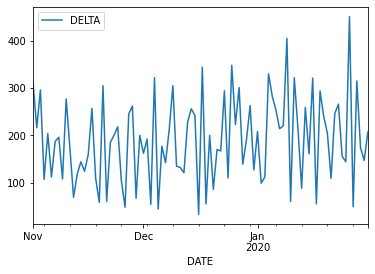

In [13]:
data_arima_prueba = data_arima[data_arima['ID'] == 357]
data_arima_prueba = data_arima_prueba.drop(['ID'], axis = 1)
data_arima_prueba.set_index('DATE', inplace = True)
data_arima_prueba.plot()

""
DATE
2019-11-01
2019-11-02
2019-11-03
2019-11-04
2019-11-05
...
2020-01-27
2020-01-28
2020-01-29


In [60]:
count = (data_arima_prueba['DELTA'] == 0).sum()
count

15

In [5]:
def selector_buenos_contadores_arima(dataframe, numero_dias_con_medida_0 = 10):
    '''
    Descripción: 
        Función que recibe un dataframe con información sobre mediciones de contadores y un umbral de días máximos en los que se admite tener
        lecturas de 0 y devuelve qué contadores son aptos para ARIMAS. 

    Inputs:
        dataframe (Pandas Dataframe): la última versión del dataframe de contadores limpiado, sin NAs, y con medidas diarias por filas.
        numero_dias_con_media_0 (int): umbral de dias con medida 0 que un contador puede tener como máximo para ser considerado bueno.

    Outputs:
        contadores_para_arima (list): lista con los identificadores de los contadores que se consideran buenos para ejecutar ARIMAS.

    '''
    contadores_para_arima = []
    for contador in range(0, len(dataframe['ID'].unique())):
        dataframe_objeto_analisis = dataframe[dataframe['ID'] == contador]
        if ((dataframe_objeto_analisis['DELTA'] == 0).sum()) <= numero_dias_con_medida_0:
            contadores_para_arima.append(contador)
    return contadores_para_arima

In [7]:
#Prueba
contadores_buenos = selector_buenos_contadores_arima(data_arima)
contadores_buenos
#Funciona

[0,
 2,
 3,
 4,
 6,
 7,
 9,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 22,
 23,
 24,
 25,
 26,
 28,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 51,
 52,
 54,
 55,
 56,
 57,
 58,
 59,
 61,
 62,
 64,
 66,
 68,
 69,
 71,
 74,
 75,
 76,
 77,
 80,
 81,
 82,
 83,
 84,
 87,
 89,
 91,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 118,
 119,
 121,
 124,
 125,
 126,
 127,
 128,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 174,
 175,
 177,
 178,
 179,
 181,
 182,
 183,
 184,
 186,
 187,
 189,
 190,
 191,
 192,
 193,
 194,
 195,
 196,
 197,
 198,
 200,
 201,
 203,
 204,
 205,
 206,
 207,
 208,
 210,
 213,
 214,
 215,
 216,
 217,
 218,
 220,
 221,
 222,
 223,
 224,
 225,
 227,
 228,

In [32]:
def arima_para_cada_contador(dataset_contadores, contadores, fecha = '2019-10-31'):
    dataset_a_estudiar = dataset_contadores[dataset_contadores['DATE'] > fecha]
    dataset_a_estudiar = dataset_a_estudiar.drop(['YEAR_DAY',
                                                    'MEAN_CONSUMPTION',
                                                    'VARIANCE_CONSUMPTION',
                                                    'WEEKDAY','IS_WEEKEND',
                                                    'sin_WEEKDAY',
                                                    'cos_WEEKDAY',
                                                    'sin_year_day',
                                                    'cos_year_day',
                                                    'PRECIPITATIONS',
                                                    'MIN_TEMP',
                                                    'MEAN_TEMP',
                                                    'MAX_TEMP',
                                                    'SUN',
                                                    'IS_GOOD'], axis=1)
    #Todas las predicciones en un dataframe
    dataframe_predicciones = dataset_a_estudiar[dataset_a_estudiar['ID'] == 0]
    dataframe_predicciones = dataframe_predicciones.drop(['ID', 'DELTA'], axis=1)
    dataframe_predicciones.set_index('DATE', inplace = True)
    for contador in contadores:
        contador_a_estudiar = dataset_a_estudiar[dataset_a_estudiar['ID'] == contador]
        #Drop ID
        contador_a_estudiar = contador_a_estudiar.drop(['ID'], axis=1)
        #Fechas a indices
        contador_a_estudiar.set_index('DATE', inplace = True)
        #MODELO POR CONTADOR
        train = contador_a_estudiar[:(92-14)]
        test = contador_a_estudiar[-14:]
        arima_model = auto_arima(train, 
                        start_p=0, 
                        d=1, 
                        start_q=0, 
                        max_p=7, 
                        max_d=7, 
                        max_q=7, 
                        start_P=0, 
                        D=1, 
                        start_Q=0, 
                        max_P=7, 
                        max_D=7, 
                        max_Q=7, 
                        m=12, 
                        seasonal=True, 
                        error_action='warn', 
                        trace=True, 
                        supress_warnings=True, 
                        stepwise=True, 
                        random_state=2517, 
                        n_fits=100)
        prediction = pd.DataFrame(arima_model.predict(n_periods = 14), index = test.index)
        dataframe_predicciones[f'predict_cont_{contador}'] = prediction
    return(dataframe_predicciones)               

In [34]:
dataframe_predicciones = arima_para_cada_contador(data, contadores_buenos)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=839.642, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=804.086, Time=0.11 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.13 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=829.202, Time=0.02 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=797.438, Time=0.34 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=798.554, Time=0.81 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=798.273, Time=0.80 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=800.227, Time=0.24 sec
 ARIMA(1,1,0)(3,1,1)[12]             : AIC=800.273, Time=1.43 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=821.192, Time=0.20 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=795.018, Time=0.38 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=799.517, Time=0.16 sec
 ARIMA(2,1,0)(3,1,0)[12]             : AIC=795.701, Time=0.82 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=795.464, Time=1.47 sec
 ARIMA(2,1,0)(1,1,1)[12]             

C:\Python3.10\lib\site-packages\pmdarima\arima\_auto_solvers.py:522: ModelFitWarning: Error fitting  ARIMA(1,1,0)(3,1,1)[12]           (if you do not want to see these warnings, run with error_action="ignore").
  warnings.warn(warning_str, ModelFitWarning)


 ARIMA(1,1,0)(3,1,1)[12]             : AIC=inf, Time=nan sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=791.888, Time=0.70 sec
 ARIMA(1,1,0)(4,1,1)[12]             : AIC=inf, Time=2.27 sec
 ARIMA(0,1,0)(3,1,0)[12]             : AIC=811.309, Time=0.46 sec
 ARIMA(2,1,0)(3,1,0)[12]             : AIC=790.514, Time=0.80 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=790.942, Time=0.48 sec
 ARIMA(2,1,0)(4,1,0)[12]             : AIC=791.011, Time=1.69 sec
 ARIMA(2,1,0)(3,1,1)[12]             : AIC=inf, Time=2.03 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=791.616, Time=1.28 sec
 ARIMA(2,1,0)(4,1,1)[12]             : AIC=inf, Time=3.99 sec
 ARIMA(3,1,0)(3,1,0)[12]             : AIC=792.225, Time=0.94 sec
 ARIMA(2,1,1)(3,1,0)[12]             : AIC=inf, Time=1.43 sec
 ARIMA(1,1,1)(3,1,0)[12]             : AIC=inf, Time=1.02 sec
 ARIMA(3,1,1)(3,1,0)[12]             : AIC=inf, Time=1.66 sec
 ARIMA(2,1,0)(3,1,0)[12] intercept   : AIC=792.491, Time=1.59 sec

Best model:  ARIMA(2,1,0)(3,1,0)[12]  

C:\Python3.10\lib\site-packages\pmdarima\arima\_auto_solvers.py:522: ModelFitWarning: Error fitting  ARIMA(1,1,1)(5,1,2)[12]           (if you do not want to see these warnings, run with error_action="ignore").
  warnings.warn(warning_str, ModelFitWarning)


 ARIMA(1,1,1)(5,1,2)[12]             : AIC=inf, Time=nan sec
 ARIMA(0,1,1)(4,1,1)[12]             : AIC=inf, Time=4.34 sec
 ARIMA(2,1,1)(4,1,1)[12]             : AIC=inf, Time=5.11 sec
 ARIMA(1,1,2)(4,1,1)[12]             : AIC=inf, Time=5.61 sec


C:\Python3.10\lib\site-packages\pmdarima\arima\_auto_solvers.py:522: ModelFitWarning: Error fitting  ARIMA(0,1,2)(4,1,1)[12]           (if you do not want to see these warnings, run with error_action="ignore").
  warnings.warn(warning_str, ModelFitWarning)


 ARIMA(0,1,2)(4,1,1)[12]             : AIC=inf, Time=nan sec
 ARIMA(2,1,2)(4,1,1)[12]             : AIC=inf, Time=6.51 sec
 ARIMA(1,1,1)(4,1,1)[12] intercept   : AIC=1036.224, Time=5.00 sec

Best model:  ARIMA(1,1,1)(4,1,1)[12]          
Total fit time: 123.395 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=804.273, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=762.908, Time=0.11 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.21 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=784.966, Time=0.03 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=762.256, Time=0.27 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=761.439, Time=0.62 sec
 ARIMA(1,1,0)(4,1,0)[12]             : AIC=763.253, Time=2.01 sec
 ARIMA(1,1,0)(3,1,1)[12]             : AIC=763.190, Time=1.30 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=0.58 sec
 ARIMA(1,1,0)(4,1,1)[12]             : AIC=inf, Time=3.53 sec
 ARIMA(0,1,0)(3,1,0)[12]             : 

C:\Python3.10\lib\site-packages\pmdarima\arima\_auto_solvers.py:522: ModelFitWarning: Error fitting  ARIMA(3,1,2)(5,1,0)[12]           (if you do not want to see these warnings, run with error_action="ignore").
  warnings.warn(warning_str, ModelFitWarning)


 ARIMA(3,1,2)(5,1,0)[12]             : AIC=inf, Time=nan sec
 ARIMA(2,1,1)(5,1,0)[12] intercept   : AIC=856.949, Time=10.07 sec

Best model:  ARIMA(2,1,1)(5,1,0)[12]          
Total fit time: 164.619 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=824.045, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=792.858, Time=0.10 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.29 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=807.935, Time=0.03 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=784.179, Time=0.32 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=786.113, Time=0.64 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=786.101, Time=0.61 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=786.427, Time=0.38 sec
 ARIMA(1,1,0)(3,1,1)[12]             : AIC=inf, Time=2.00 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=792.859, Time=0.20 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=784.892, Time=0.33 sec
 ARIMA(1,1,1)(2,1,0)[12]       

C:\Python3.10\lib\site-packages\pmdarima\arima\_auto_solvers.py:522: ModelFitWarning: Error fitting  ARIMA(3,1,0)(3,1,1)[12]           (if you do not want to see these warnings, run with error_action="ignore").
  warnings.warn(warning_str, ModelFitWarning)


 ARIMA(3,1,0)(3,1,1)[12]             : AIC=inf, Time=nan sec
 ARIMA(3,1,0)(2,1,2)[12]             : AIC=inf, Time=1.71 sec
 ARIMA(3,1,0)(1,1,2)[12]             : AIC=inf, Time=1.31 sec
 ARIMA(3,1,0)(3,1,2)[12]             : AIC=inf, Time=3.12 sec
 ARIMA(4,1,0)(2,1,1)[12]             : AIC=822.617, Time=1.08 sec
 ARIMA(4,1,0)(1,1,1)[12]             : AIC=827.827, Time=0.50 sec
 ARIMA(4,1,0)(2,1,0)[12]             : AIC=822.411, Time=0.64 sec
 ARIMA(4,1,0)(1,1,0)[12]             : AIC=832.835, Time=0.24 sec
 ARIMA(4,1,0)(3,1,0)[12]             : AIC=823.232, Time=1.34 sec
 ARIMA(4,1,0)(3,1,1)[12]             : AIC=inf, Time=3.46 sec
 ARIMA(5,1,0)(2,1,0)[12]             : AIC=823.958, Time=0.76 sec
 ARIMA(4,1,1)(2,1,0)[12]             : AIC=816.585, Time=1.20 sec
 ARIMA(4,1,1)(1,1,0)[12]             : AIC=823.037, Time=0.65 sec
 ARIMA(4,1,1)(3,1,0)[12]             : AIC=817.663, Time=3.34 sec
 ARIMA(4,1,1)(2,1,1)[12]             : AIC=817.553, Time=1.49 sec
 ARIMA(4,1,1)(1,1,1)[12]       

C:\Python3.10\lib\site-packages\pmdarima\arima\_auto_solvers.py:522: ModelFitWarning: Error fitting  ARIMA(1,1,0)(4,1,2)[12]           (if you do not want to see these warnings, run with error_action="ignore").
  warnings.warn(warning_str, ModelFitWarning)


 ARIMA(1,1,0)(4,1,2)[12]             : AIC=inf, Time=nan sec
 ARIMA(0,1,0)(3,1,1)[12]             : AIC=inf, Time=1.83 sec
 ARIMA(2,1,0)(3,1,1)[12]             : AIC=836.840, Time=1.91 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=0.87 sec
 ARIMA(2,1,0)(3,1,0)[12]             : AIC=834.942, Time=0.92 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=842.892, Time=0.36 sec
 ARIMA(2,1,0)(4,1,0)[12]             : AIC=inf, Time=1.89 sec
 ARIMA(2,1,0)(4,1,1)[12]             : AIC=838.844, Time=2.80 sec
 ARIMA(3,1,0)(3,1,0)[12]             : AIC=834.256, Time=0.89 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=841.681, Time=0.38 sec
 ARIMA(3,1,0)(4,1,0)[12]             : AIC=836.087, Time=2.22 sec
 ARIMA(3,1,0)(3,1,1)[12]             : AIC=836.033, Time=2.85 sec
 ARIMA(3,1,0)(2,1,1)[12]             : AIC=inf, Time=0.86 sec
 ARIMA(3,1,0)(4,1,1)[12]             : AIC=838.120, Time=5.17 sec
 ARIMA(4,1,0)(3,1,0)[12]             : AIC=835.937, Time=1.93 sec
 ARIMA(3,1,1)(3,1,0)[12]       

C:\Python3.10\lib\site-packages\pmdarima\arima\_auto_solvers.py:522: ModelFitWarning: Error fitting  ARIMA(1,1,0)(3,1,1)[12]           (if you do not want to see these warnings, run with error_action="ignore").
  warnings.warn(warning_str, ModelFitWarning)


 ARIMA(1,1,0)(3,1,1)[12]             : AIC=inf, Time=nan sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=953.481, Time=0.20 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=930.050, Time=0.38 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=941.725, Time=0.16 sec
 ARIMA(2,1,0)(3,1,0)[12]             : AIC=930.999, Time=0.93 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=931.074, Time=1.20 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=931.805, Time=0.39 sec
 ARIMA(2,1,0)(3,1,1)[12]             : AIC=inf, Time=1.73 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=922.359, Time=0.46 sec
 ARIMA(3,1,0)(1,1,0)[12]             : AIC=929.954, Time=0.21 sec
 ARIMA(3,1,0)(3,1,0)[12]             : AIC=923.239, Time=1.61 sec
 ARIMA(3,1,0)(2,1,1)[12]             : AIC=922.610, Time=1.09 sec
 ARIMA(3,1,0)(1,1,1)[12]             : AIC=inf, Time=0.63 sec
 ARIMA(3,1,0)(3,1,1)[12]             : AIC=inf, Time=3.35 sec
 ARIMA(4,1,0)(2,1,0)[12]             : AIC=923.556, Time=0.95 sec
 ARIMA(3,1,1)(2,1,0)[12]   

C:\Users\Manuel\AppData\Local\Temp/ipykernel_6100/2491189978.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataframe_predicciones[f'predict_cont_{contador}'] = prediction


 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.30 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=859.447, Time=0.03 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=831.452, Time=0.30 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=831.550, Time=0.80 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=831.202, Time=0.78 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=829.208, Time=0.48 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=inf, Time=0.32 sec
 ARIMA(1,1,0)(1,1,2)[12]             : AIC=inf, Time=0.54 sec
 ARIMA(1,1,0)(0,1,2)[12]             : AIC=829.191, Time=0.74 sec
 ARIMA(1,1,0)(0,1,3)[12]             : AIC=831.187, Time=1.15 sec
 ARIMA(1,1,0)(1,1,3)[12]             : AIC=inf, Time=2.15 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=850.374, Time=0.33 sec
 ARIMA(2,1,0)(0,1,2)[12]             : AIC=799.711, Time=0.50 sec
 ARIMA(2,1,0)(0,1,1)[12]             : AIC=797.997, Time=0.42 sec
 ARIMA(2,1,0)(0,1,0)[12]             : AIC=819.473, Time=0.07 sec
 ARIMA(2,1,0)(1,1,1)[12]  

C:\Users\Manuel\AppData\Local\Temp/ipykernel_6100/2491189978.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataframe_predicciones[f'predict_cont_{contador}'] = prediction


 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.24 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=808.076, Time=0.04 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=775.048, Time=0.31 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=775.102, Time=0.64 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=1.28 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.50 sec
 ARIMA(1,1,0)(3,1,1)[12]             : AIC=inf, Time=2.49 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=799.324, Time=0.21 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=773.458, Time=0.47 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=778.899, Time=0.16 sec
 ARIMA(2,1,0)(3,1,0)[12]             : AIC=773.532, Time=0.86 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=1.42 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=0.62 sec
 ARIMA(2,1,0)(3,1,1)[12]             : AIC=inf, Time=3.15 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=764.557, Time=0.48 sec
 ARIMA(3,1,0)(1,1,0)[12]             :

C:\Users\Manuel\AppData\Local\Temp/ipykernel_6100/2491189978.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataframe_predicciones[f'predict_cont_{contador}'] = prediction


 ARIMA(0,1,1)(0,1,1)[12]             : AIC=793.895, Time=0.17 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=805.207, Time=0.03 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=0.45 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=795.810, Time=0.41 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=796.033, Time=0.11 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=1.12 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=814.555, Time=0.12 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=793.551, Time=0.52 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=806.405, Time=0.09 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=inf, Time=0.70 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=inf, Time=0.63 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=795.772, Time=0.22 sec
 ARIMA(1,1,1)(1,1,2)[12]             : AIC=inf, Time=1.37 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=801.287, Time=0.16 sec
 ARIMA(2,1,1)(0,1,1)[12]             : AIC=796.647, Time=0.45 sec
 ARIMA(1,1,2)(0,1,1)[12]      

C:\Users\Manuel\AppData\Local\Temp/ipykernel_6100/2491189978.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataframe_predicciones[f'predict_cont_{contador}'] = prediction


 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.29 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=924.606, Time=0.02 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=906.532, Time=0.30 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=902.149, Time=0.68 sec
 ARIMA(1,1,0)(4,1,0)[12]             : AIC=904.056, Time=1.41 sec
 ARIMA(1,1,0)(3,1,1)[12]             : AIC=904.087, Time=2.57 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=0.83 sec
 ARIMA(1,1,0)(4,1,1)[12]             : AIC=inf, Time=3.60 sec
 ARIMA(0,1,0)(3,1,0)[12]             : AIC=927.874, Time=0.59 sec
 ARIMA(2,1,0)(3,1,0)[12]             : AIC=900.406, Time=0.98 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=906.284, Time=0.42 sec
 ARIMA(2,1,0)(4,1,0)[12]             : AIC=902.406, Time=2.13 sec
 ARIMA(2,1,0)(3,1,1)[12]             : AIC=902.851, Time=3.03 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=1.37 sec
 ARIMA(2,1,0)(4,1,1)[12]             : AIC=inf, Time=3.02 sec
 ARIMA(3,1,0)(3,1,0)[12]      

C:\Users\Manuel\AppData\Local\Temp/ipykernel_6100/2491189978.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataframe_predicciones[f'predict_cont_{contador}'] = prediction


 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.16 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=876.008, Time=0.04 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=864.209, Time=0.28 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=866.182, Time=0.65 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=866.072, Time=0.66 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.48 sec
 ARIMA(1,1,0)(3,1,1)[12]             : AIC=867.976, Time=1.35 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=878.471, Time=0.25 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=861.299, Time=0.40 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=867.697, Time=0.17 sec
 ARIMA(2,1,0)(3,1,0)[12]             : AIC=863.283, Time=0.81 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=863.270, Time=0.87 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=0.65 sec
 ARIMA(2,1,0)(3,1,1)[12]             : AIC=inf, Time=2.18 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=857.855, Time=0.46 sec
 ARIMA(3,1,0)(1,1,0)[12]  

C:\Users\Manuel\AppData\Local\Temp/ipykernel_6100/2491189978.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataframe_predicciones[f'predict_cont_{contador}'] = prediction


 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.26 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=925.170, Time=0.04 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=901.051, Time=0.36 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=899.565, Time=0.83 sec
 ARIMA(1,1,0)(4,1,0)[12]             : AIC=898.627, Time=1.55 sec
 ARIMA(1,1,0)(5,1,0)[12]             : AIC=inf, Time=6.01 sec
 ARIMA(1,1,0)(4,1,1)[12]             : AIC=inf, Time=4.47 sec
 ARIMA(1,1,0)(3,1,1)[12]             : AIC=900.642, Time=1.56 sec
 ARIMA(1,1,0)(5,1,1)[12]             : AIC=inf, Time=10.06 sec
 ARIMA(0,1,0)(4,1,0)[12]             : AIC=923.323, Time=1.65 sec
 ARIMA(2,1,0)(4,1,0)[12]             : AIC=893.744, Time=1.98 sec
 ARIMA(2,1,0)(3,1,0)[12]             : AIC=894.922, Time=0.86 sec
 ARIMA(2,1,0)(5,1,0)[12]             : AIC=inf, Time=6.48 sec
 ARIMA(2,1,0)(4,1,1)[12]             : AIC=inf, Time=5.16 sec
 ARIMA(2,1,0)(3,1,1)[12]             : AIC=inf, Time=2.83 sec
 ARIMA(2,1,0)(5,1,1)[12]             

C:\Users\Manuel\AppData\Local\Temp/ipykernel_6100/2491189978.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataframe_predicciones[f'predict_cont_{contador}'] = prediction


 ARIMA(1,1,0)(1,1,0)[12]             : AIC=777.637, Time=0.09 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=763.746, Time=0.45 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=787.765, Time=0.06 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=757.991, Time=0.44 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=756.231, Time=0.30 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=758.042, Time=0.67 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=inf, Time=0.49 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=797.138, Time=0.07 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=757.456, Time=0.18 sec
 ARIMA(0,1,2)(1,1,0)[12]             : AIC=757.307, Time=0.32 sec
 ARIMA(1,1,2)(1,1,0)[12]             : AIC=757.728, Time=0.50 sec
 ARIMA(0,1,1)(1,1,0)[12] intercept   : AIC=inf, Time=0.41 sec

Best model:  ARIMA(0,1,1)(1,1,0)[12]          
Total fit time: 4.013 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=829.459, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]     

C:\Users\Manuel\AppData\Local\Temp/ipykernel_6100/2491189978.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataframe_predicciones[f'predict_cont_{contador}'] = prediction


 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.18 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=814.001, Time=0.04 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=795.160, Time=0.29 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=796.875, Time=0.59 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=796.662, Time=0.95 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=796.235, Time=0.23 sec
 ARIMA(1,1,0)(3,1,1)[12]             : AIC=inf, Time=1.62 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=809.367, Time=0.33 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=784.789, Time=0.39 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=786.900, Time=0.17 sec
 ARIMA(2,1,0)(3,1,0)[12]             : AIC=786.666, Time=0.96 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=1.79 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=0.46 sec
 ARIMA(2,1,0)(3,1,1)[12]             : AIC=inf, Time=2.77 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=784.380, Time=0.45 sec
 ARIMA(3,1,0)(1,1,0)[12]      

C:\Users\Manuel\AppData\Local\Temp/ipykernel_6100/2491189978.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataframe_predicciones[f'predict_cont_{contador}'] = prediction


 ARIMA(1,1,0)(1,1,0)[12]             : AIC=998.908, Time=0.15 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.24 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=1022.309, Time=0.02 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=996.936, Time=0.47 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=997.968, Time=0.78 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=0.77 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.33 sec
 ARIMA(1,1,0)(3,1,1)[12]             : AIC=inf, Time=2.49 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=995.206, Time=0.42 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=997.546, Time=0.12 sec
 ARIMA(0,1,0)(3,1,0)[12]             : AIC=996.241, Time=0.67 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=inf, Time=0.58 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=0.21 sec
 ARIMA(0,1,0)(3,1,1)[12]             : AIC=inf, Time=1.26 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=996.154, Time=0.43 sec
 ARIMA(1,1,1)(2,1,0)[12]             

C:\Users\Manuel\AppData\Local\Temp/ipykernel_6100/2491189978.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataframe_predicciones[f'predict_cont_{contador}'] = prediction


 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.31 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=840.734, Time=0.04 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=820.507, Time=0.53 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=819.465, Time=0.65 sec
 ARIMA(1,1,0)(4,1,0)[12]             : AIC=819.664, Time=1.44 sec
 ARIMA(1,1,0)(3,1,1)[12]             : AIC=inf, Time=2.11 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=0.73 sec
 ARIMA(1,1,0)(4,1,1)[12]             : AIC=inf, Time=2.56 sec
 ARIMA(0,1,0)(3,1,0)[12]             : AIC=818.659, Time=0.46 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(4,1,0)[12]             : AIC=818.930, Time=0.94 sec
 ARIMA(0,1,0)(3,1,1)[12]             : AIC=inf, Time=1.59 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=inf, Time=0.74 sec
 ARIMA(0,1,0)(4,1,1)[12]             : AIC=inf, Time=3.00 sec
 ARIMA(0,1,1)(3,1,0)[12]             : AIC=810.786, Time=1.47 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC

C:\Users\Manuel\AppData\Local\Temp/ipykernel_6100/2491189978.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataframe_predicciones[f'predict_cont_{contador}'] = prediction


 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.17 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=855.636, Time=0.02 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=818.729, Time=0.28 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=815.814, Time=0.84 sec
 ARIMA(1,1,0)(4,1,0)[12]             : AIC=816.790, Time=1.54 sec
 ARIMA(1,1,0)(3,1,1)[12]             : AIC=inf, Time=2.23 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=1.08 sec
 ARIMA(1,1,0)(4,1,1)[12]             : AIC=inf, Time=2.99 sec
 ARIMA(0,1,0)(3,1,0)[12]             : AIC=832.192, Time=0.45 sec
 ARIMA(2,1,0)(3,1,0)[12]             : AIC=811.176, Time=0.96 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=811.609, Time=0.41 sec
 ARIMA(2,1,0)(4,1,0)[12]             : AIC=811.913, Time=1.71 sec
 ARIMA(2,1,0)(3,1,1)[12]             : AIC=inf, Time=2.50 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=1.18 sec
 ARIMA(2,1,0)(4,1,1)[12]             : AIC=inf, Time=3.62 sec
 ARIMA(3,1,0)(3,1,0)[12]             :

C:\Users\Manuel\AppData\Local\Temp/ipykernel_6100/2491189978.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataframe_predicciones[f'predict_cont_{contador}'] = prediction


 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.19 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=865.536, Time=0.03 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=839.086, Time=0.26 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=839.194, Time=0.60 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=0.95 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.37 sec
 ARIMA(1,1,0)(3,1,1)[12]             : AIC=inf, Time=1.67 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=850.691, Time=0.18 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=836.236, Time=0.32 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=843.642, Time=0.12 sec
 ARIMA(2,1,0)(3,1,0)[12]             : AIC=835.502, Time=0.76 sec
 ARIMA(2,1,0)(4,1,0)[12]             : AIC=inf, Time=1.66 sec
 ARIMA(2,1,0)(3,1,1)[12]             : AIC=inf, Time=2.06 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=1.17 sec
 ARIMA(2,1,0)(4,1,1)[12]             : AIC=inf, Time=5.04 sec
 ARIMA(3,1,0)(3,1,0)[12]             : AIC

C:\Python3.10\lib\site-packages\pmdarima\arima\_auto_solvers.py:522: ModelFitWarning: Error fitting  ARIMA(0,1,0)(5,1,0)[12]           (if you do not want to see these warnings, run with error_action="ignore").
  warnings.warn(warning_str, ModelFitWarning)


 ARIMA(0,1,0)(5,1,0)[12]             : AIC=inf, Time=nan sec
 ARIMA(0,1,2)(5,1,0)[12]             : AIC=inf, Time=7.22 sec
 ARIMA(2,1,0)(5,1,0)[12]             : AIC=inf, Time=6.97 sec
 ARIMA(2,1,2)(5,1,0)[12]             : AIC=inf, Time=9.22 sec
 ARIMA(1,1,1)(5,1,0)[12] intercept   : AIC=816.879, Time=8.22 sec

Best model:  ARIMA(1,1,1)(5,1,0)[12]          
Total fit time: 128.160 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1082.527, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1063.764, Time=0.16 sec


C:\Users\Manuel\AppData\Local\Temp/ipykernel_6100/2491189978.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataframe_predicciones[f'predict_cont_{contador}'] = prediction


 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.29 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=1079.861, Time=0.04 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=1053.231, Time=0.40 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=1054.223, Time=0.83 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=1053.182, Time=0.64 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.41 sec
 ARIMA(1,1,0)(3,1,1)[12]             : AIC=inf, Time=2.03 sec
 ARIMA(1,1,0)(2,1,2)[12]             : AIC=1054.564, Time=1.24 sec
 ARIMA(1,1,0)(1,1,2)[12]             : AIC=inf, Time=1.12 sec
 ARIMA(1,1,0)(3,1,2)[12]             : AIC=inf, Time=2.48 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=inf, Time=0.76 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=1052.314, Time=0.78 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=0.33 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=1052.739, Time=0.57 sec
 ARIMA(2,1,0)(3,1,1)[12]             : AIC=1054.314, Time=1.79 sec
 ARIMA(2,1,0)(2,1,2)[12]      

C:\Users\Manuel\AppData\Local\Temp/ipykernel_6100/2491189978.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataframe_predicciones[f'predict_cont_{contador}'] = prediction


 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.26 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=767.383, Time=0.02 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=734.141, Time=0.23 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=735.822, Time=0.56 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=0.73 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=733.887, Time=0.31 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=inf, Time=0.21 sec
 ARIMA(1,1,0)(1,1,2)[12]             : AIC=735.812, Time=1.16 sec
 ARIMA(1,1,0)(0,1,2)[12]             : AIC=733.874, Time=0.62 sec
 ARIMA(1,1,0)(0,1,3)[12]             : AIC=735.773, Time=1.59 sec
 ARIMA(1,1,0)(1,1,3)[12]             : AIC=inf, Time=2.03 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=740.222, Time=0.46 sec
 ARIMA(2,1,0)(0,1,2)[12]             : AIC=726.049, Time=0.65 sec
 ARIMA(2,1,0)(0,1,1)[12]             : AIC=inf, Time=0.33 sec
 ARIMA(2,1,0)(1,1,2)[12]             : AIC=inf, Time=0.96 sec
 ARIMA(2,1,0)(0,1,3)[12]          

C:\Users\Manuel\AppData\Local\Temp/ipykernel_6100/2491189978.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataframe_predicciones[f'predict_cont_{contador}'] = prediction


 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.21 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=846.799, Time=0.03 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=831.554, Time=0.20 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=832.325, Time=0.53 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=0.59 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.38 sec
 ARIMA(1,1,0)(3,1,1)[12]             : AIC=inf, Time=2.02 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=836.950, Time=0.16 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=830.236, Time=0.34 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=831.373, Time=0.12 sec
 ARIMA(2,1,0)(3,1,0)[12]             : AIC=831.893, Time=0.72 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=1.17 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=0.50 sec
 ARIMA(2,1,0)(3,1,1)[12]             : AIC=inf, Time=2.43 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=830.404, Time=0.35 sec
 ARIMA(2,1,1)(2,1,0)[12]             :

C:\Users\Manuel\AppData\Local\Temp/ipykernel_6100/2491189978.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataframe_predicciones[f'predict_cont_{contador}'] = prediction


 ARIMA(0,1,1)(0,1,1)[12]             : AIC=809.893, Time=0.21 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=817.990, Time=0.04 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=0.45 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=inf, Time=0.59 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=813.953, Time=0.13 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=0.81 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=831.984, Time=0.08 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=0.19 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=inf, Time=0.16 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=827.879, Time=0.18 sec
 ARIMA(1,1,2)(0,1,1)[12]             : AIC=inf, Time=0.22 sec
 ARIMA(0,1,1)(0,1,1)[12] intercept   : AIC=811.603, Time=0.25 sec

Best model:  ARIMA(0,1,1)(0,1,1)[12]          
Total fit time: 3.428 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=851.942, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=83

C:\Users\Manuel\AppData\Local\Temp/ipykernel_6100/2491189978.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataframe_predicciones[f'predict_cont_{contador}'] = prediction


 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.18 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=841.774, Time=0.03 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=826.336, Time=0.24 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=825.858, Time=0.62 sec
 ARIMA(1,1,0)(4,1,0)[12]             : AIC=827.853, Time=1.33 sec
 ARIMA(1,1,0)(3,1,1)[12]             : AIC=inf, Time=2.15 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=825.821, Time=0.54 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.34 sec
 ARIMA(1,1,0)(2,1,2)[12]             : AIC=inf, Time=1.19 sec
 ARIMA(1,1,0)(1,1,2)[12]             : AIC=inf, Time=0.43 sec
 ARIMA(1,1,0)(3,1,2)[12]             : AIC=inf, Time=2.46 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=inf, Time=0.76 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=825.182, Time=0.83 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=0.54 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=826.192, Time=0.33 sec
 ARIMA(2,1,0)(3,1,1)[12]             : AIC

C:\Users\Manuel\AppData\Local\Temp/ipykernel_6100/2491189978.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataframe_predicciones[f'predict_cont_{contador}'] = prediction


 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.22 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=822.122, Time=0.03 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=805.742, Time=0.27 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=802.897, Time=0.71 sec
 ARIMA(1,1,0)(4,1,0)[12]             : AIC=804.643, Time=1.37 sec
 ARIMA(1,1,0)(3,1,1)[12]             : AIC=inf, Time=1.41 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=804.595, Time=1.13 sec
 ARIMA(1,1,0)(4,1,1)[12]             : AIC=inf, Time=3.07 sec
 ARIMA(0,1,0)(3,1,0)[12]             : AIC=824.042, Time=0.69 sec
 ARIMA(2,1,0)(3,1,0)[12]             : AIC=797.731, Time=0.93 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=800.432, Time=0.43 sec
 ARIMA(2,1,0)(4,1,0)[12]             : AIC=799.721, Time=2.06 sec
 ARIMA(2,1,0)(3,1,1)[12]             : AIC=inf, Time=2.05 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=798.631, Time=0.92 sec
 ARIMA(2,1,0)(4,1,1)[12]             : AIC=inf, Time=4.60 sec
 ARIMA(3,1,0)(3,1,0)[12]      

C:\Users\Manuel\AppData\Local\Temp/ipykernel_6100/2491189978.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataframe_predicciones[f'predict_cont_{contador}'] = prediction


 ARIMA(1,1,0)(1,1,0)[12]             : AIC=731.593, Time=0.14 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.25 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=749.884, Time=0.04 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=730.882, Time=0.40 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=732.671, Time=0.75 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=0.68 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.51 sec
 ARIMA(1,1,0)(3,1,1)[12]             : AIC=inf, Time=1.88 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=764.125, Time=0.21 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=724.212, Time=0.39 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=728.370, Time=0.19 sec
 ARIMA(2,1,0)(3,1,0)[12]             : AIC=725.965, Time=1.06 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=1.12 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=0.77 sec
 ARIMA(2,1,0)(3,1,1)[12]             : AIC=inf, Time=2.07 sec
 ARIMA(3,1,0)(2,1,0)[12]             :

C:\Users\Manuel\AppData\Local\Temp/ipykernel_6100/2491189978.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataframe_predicciones[f'predict_cont_{contador}'] = prediction


 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.25 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=841.718, Time=0.03 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=813.903, Time=0.33 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=813.161, Time=0.73 sec
 ARIMA(1,1,0)(4,1,0)[12]             : AIC=814.507, Time=1.42 sec
 ARIMA(1,1,0)(3,1,1)[12]             : AIC=inf, Time=2.38 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=812.660, Time=0.77 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.40 sec
 ARIMA(1,1,0)(2,1,2)[12]             : AIC=inf, Time=1.78 sec
 ARIMA(1,1,0)(1,1,2)[12]             : AIC=inf, Time=1.57 sec
 ARIMA(1,1,0)(3,1,2)[12]             : AIC=inf, Time=0.97 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=811.822, Time=0.72 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=813.290, Time=0.20 sec
 ARIMA(0,1,0)(3,1,1)[12]             : AIC=813.791, Time=1.11 sec
 ARIMA(0,1,0)(2,1,2)[12]             :

C:\Users\Manuel\AppData\Local\Temp/ipykernel_6100/2491189978.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataframe_predicciones[f'predict_cont_{contador}'] = prediction


 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.30 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=826.472, Time=0.04 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=799.636, Time=0.34 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.66 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=inf, Time=0.28 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=0.85 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=827.009, Time=0.08 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=796.000, Time=0.16 sec
 ARIMA(2,1,0)(0,1,0)[12]             : AIC=822.261, Time=0.08 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=795.173, Time=0.41 sec
 ARIMA(2,1,0)(3,1,0)[12]             : AIC=789.719, Time=1.14 sec
 ARIMA(2,1,0)(4,1,0)[12]             : AIC=791.219, Time=1.95 sec
 ARIMA(2,1,0)(3,1,1)[12]             : AIC=inf, Time=2.81 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=1.49 sec
 ARIMA(2,1,0)(4,1,1)[12]             : AIC=inf, Time=4.70 sec
 ARIMA(1,1,0)(3,1,0)[12]             :

C:\Users\Manuel\AppData\Local\Temp/ipykernel_6100/2491189978.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataframe_predicciones[f'predict_cont_{contador}'] = prediction


 ARIMA(1,1,0)(1,1,0)[12]             : AIC=834.944, Time=0.16 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.34 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=845.834, Time=0.03 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=829.954, Time=0.31 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=831.953, Time=0.66 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=831.953, Time=0.78 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=831.875, Time=0.38 sec
 ARIMA(1,1,0)(3,1,1)[12]             : AIC=inf, Time=1.86 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=850.834, Time=0.23 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=819.327, Time=0.43 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=822.518, Time=0.17 sec
 ARIMA(2,1,0)(3,1,0)[12]             : AIC=821.207, Time=0.73 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=821.279, Time=0.78 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=821.207, Time=0.36 sec
 ARIMA(2,1,0)(3,1,1)[12]             : AIC=inf, Time=1.02 sec
 ARIMA(3,1,0)(2,1,0)[1

C:\Users\Manuel\AppData\Local\Temp/ipykernel_6100/2491189978.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataframe_predicciones[f'predict_cont_{contador}'] = prediction


 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.19 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=901.934, Time=0.03 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=893.876, Time=0.27 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=894.537, Time=0.30 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=892.697, Time=0.23 sec
 ARIMA(1,1,0)(0,1,2)[12]             : AIC=894.535, Time=0.51 sec
 ARIMA(1,1,0)(1,1,2)[12]             : AIC=896.528, Time=0.64 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=903.883, Time=0.13 sec
 ARIMA(2,1,0)(0,1,1)[12]             : AIC=885.009, Time=0.29 sec
 ARIMA(2,1,0)(0,1,0)[12]             : AIC=894.713, Time=0.03 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=886.794, Time=0.36 sec
 ARIMA(2,1,0)(0,1,2)[12]             : AIC=886.698, Time=0.67 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=886.396, Time=0.21 sec
 ARIMA(2,1,0)(1,1,2)[12]             : AIC=888.662, Time=1.09 sec
 ARIMA(3,1,0)(0,1,1)[12]             : AIC=886.620, Time=0.38 sec
 ARIMA(2,1,1)(

C:\Users\Manuel\AppData\Local\Temp/ipykernel_6100/2491189978.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataframe_predicciones[f'predict_cont_{contador}'] = prediction


 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.31 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=826.967, Time=0.04 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=801.873, Time=0.46 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=798.414, Time=0.78 sec
 ARIMA(1,1,0)(4,1,0)[12]             : AIC=800.276, Time=1.48 sec
 ARIMA(1,1,0)(3,1,1)[12]             : AIC=800.316, Time=1.37 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=801.119, Time=0.79 sec
 ARIMA(1,1,0)(4,1,1)[12]             : AIC=inf, Time=4.15 sec
 ARIMA(0,1,0)(3,1,0)[12]             : AIC=822.662, Time=0.54 sec
 ARIMA(2,1,0)(3,1,0)[12]             : AIC=778.472, Time=0.87 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=778.832, Time=0.40 sec
 ARIMA(2,1,0)(4,1,0)[12]             : AIC=779.452, Time=1.70 sec
 ARIMA(2,1,0)(3,1,1)[12]             : AIC=779.782, Time=1.63 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=779.782, Time=0.94 sec
 ARIMA(2,1,0)(4,1,1)[12]             : AIC=781.668, Time=5.21 sec
 ARIMA(3,1,0)(3,1,

C:\Users\Manuel\AppData\Local\Temp/ipykernel_6100/2491189978.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataframe_predicciones[f'predict_cont_{contador}'] = prediction


 ARIMA(0,1,1)(0,1,1)[12]             : AIC=809.042, Time=0.17 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=825.103, Time=0.05 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=811.033, Time=0.35 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=811.025, Time=0.44 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=813.715, Time=0.12 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=0.91 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=828.270, Time=0.19 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=810.308, Time=0.29 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=810.094, Time=0.35 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=821.294, Time=0.14 sec
 ARIMA(1,1,2)(0,1,1)[12]             : AIC=inf, Time=0.54 sec
 ARIMA(0,1,1)(0,1,1)[12] intercept   : AIC=811.037, Time=0.36 sec

Best model:  ARIMA(0,1,1)(0,1,1)[12]          
Total fit time: 4.010 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=844.052, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]     

C:\Users\Manuel\AppData\Local\Temp/ipykernel_6100/2491189978.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataframe_predicciones[f'predict_cont_{contador}'] = prediction


 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.17 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=831.852, Time=0.04 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=800.522, Time=0.30 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=801.002, Time=0.87 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=0.84 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=798.744, Time=0.41 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=inf, Time=0.27 sec
 ARIMA(1,1,0)(1,1,2)[12]             : AIC=800.193, Time=1.12 sec
 ARIMA(1,1,0)(0,1,2)[12]             : AIC=799.730, Time=0.41 sec
 ARIMA(1,1,0)(2,1,2)[12]             : AIC=inf, Time=1.03 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=0.17 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=784.990, Time=0.31 sec
 ARIMA(2,1,0)(0,1,1)[12]             : AIC=783.597, Time=0.21 sec
 ARIMA(2,1,0)(0,1,0)[12]             : AIC=800.733, Time=0.06 sec
 ARIMA(2,1,0)(0,1,2)[12]             : AIC=785.182, Time=0.58 sec
 ARIMA(2,1,0)(1,1,0)[12]      

C:\Users\Manuel\AppData\Local\Temp/ipykernel_6100/2491189978.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataframe_predicciones[f'predict_cont_{contador}'] = prediction


 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.20 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=730.410, Time=0.03 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=716.424, Time=0.22 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=716.393, Time=0.54 sec
 ARIMA(1,1,0)(4,1,0)[12]             : AIC=716.000, Time=1.19 sec
 ARIMA(1,1,0)(5,1,0)[12]             : AIC=717.816, Time=3.02 sec
 ARIMA(1,1,0)(4,1,1)[12]             : AIC=717.816, Time=2.78 sec
 ARIMA(1,1,0)(3,1,1)[12]             : AIC=inf, Time=1.67 sec
 ARIMA(1,1,0)(5,1,1)[12]             : AIC=719.816, Time=4.40 sec
 ARIMA(0,1,0)(4,1,0)[12]             : AIC=722.849, Time=1.36 sec
 ARIMA(2,1,0)(4,1,0)[12]             : AIC=702.593, Time=1.56 sec
 ARIMA(2,1,0)(3,1,0)[12]             : AIC=705.228, Time=0.74 sec
 ARIMA(2,1,0)(5,1,0)[12]             : AIC=703.685, Time=3.59 sec
 ARIMA(2,1,0)(4,1,1)[12]             : AIC=703.773, Time=2.17 sec
 ARIMA(2,1,0)(3,1,1)[12]             : AIC=inf, Time=1.63 sec
 ARIMA(2,1,0)(5,1,1)[1

C:\Users\Manuel\AppData\Local\Temp/ipykernel_6100/2491189978.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataframe_predicciones[f'predict_cont_{contador}'] = prediction


 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.25 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=800.399, Time=0.03 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=786.910, Time=0.28 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=786.606, Time=0.60 sec
 ARIMA(1,1,0)(4,1,0)[12]             : AIC=784.263, Time=1.38 sec
 ARIMA(1,1,0)(5,1,0)[12]             : AIC=786.004, Time=3.20 sec
 ARIMA(1,1,0)(4,1,1)[12]             : AIC=inf, Time=3.67 sec
 ARIMA(1,1,0)(3,1,1)[12]             : AIC=inf, Time=1.65 sec
 ARIMA(1,1,0)(5,1,1)[12]             : AIC=inf, Time=5.13 sec
 ARIMA(0,1,0)(4,1,0)[12]             : AIC=791.245, Time=1.14 sec
 ARIMA(2,1,0)(4,1,0)[12]             : AIC=785.739, Time=1.61 sec
 ARIMA(1,1,1)(4,1,0)[12]             : AIC=785.171, Time=2.44 sec
 ARIMA(0,1,1)(4,1,0)[12]             : AIC=783.229, Time=1.41 sec
 ARIMA(0,1,1)(3,1,0)[12]             : AIC=784.857, Time=0.72 sec
 ARIMA(0,1,1)(5,1,0)[12]             : AIC=784.974, Time=3.94 sec
 ARIMA(0,1,1)(4,1,1)[12]  

C:\Users\Manuel\AppData\Local\Temp/ipykernel_6100/2491189978.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataframe_predicciones[f'predict_cont_{contador}'] = prediction


 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.28 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=889.203, Time=0.02 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=870.705, Time=0.28 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=861.896, Time=0.69 sec
 ARIMA(1,1,0)(4,1,0)[12]             : AIC=inf, Time=1.76 sec
 ARIMA(1,1,0)(3,1,1)[12]             : AIC=862.797, Time=2.12 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=0.93 sec
 ARIMA(1,1,0)(4,1,1)[12]             : AIC=862.991, Time=3.56 sec
 ARIMA(0,1,0)(3,1,0)[12]             : AIC=862.358, Time=0.47 sec
 ARIMA(2,1,0)(3,1,0)[12]             : AIC=845.440, Time=1.55 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=852.721, Time=0.51 sec
 ARIMA(2,1,0)(4,1,0)[12]             : AIC=inf, Time=2.92 sec
 ARIMA(2,1,0)(3,1,1)[12]             : AIC=inf, Time=2.37 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=1.25 sec
 ARIMA(2,1,0)(4,1,1)[12]             : AIC=849.312, Time=4.30 sec
 ARIMA(3,1,0)(3,1,0)[12]          

C:\Users\Manuel\AppData\Local\Temp/ipykernel_6100/2491189978.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataframe_predicciones[f'predict_cont_{contador}'] = prediction


 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.20 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=835.639, Time=0.03 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=818.653, Time=0.27 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.52 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=inf, Time=0.25 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=0.81 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=827.037, Time=0.07 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=815.798, Time=0.17 sec
 ARIMA(2,1,0)(0,1,0)[12]             : AIC=834.670, Time=0.05 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=817.683, Time=0.37 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=0.68 sec
 ARIMA(2,1,0)(0,1,1)[12]             : AIC=inf, Time=0.46 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=1.39 sec
 ARIMA(3,1,0)(1,1,0)[12]             : AIC=810.119, Time=0.17 sec
 ARIMA(3,1,0)(0,1,0)[12]             : AIC=821.988, Time=0.08 sec
 ARIMA(3,1,0)(2,1,0)[12]             :

C:\Users\Manuel\AppData\Local\Temp/ipykernel_6100/2491189978.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataframe_predicciones[f'predict_cont_{contador}'] = prediction


 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.34 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=903.515, Time=0.04 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=873.055, Time=0.30 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=874.987, Time=0.66 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=874.990, Time=0.89 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=874.623, Time=0.32 sec
 ARIMA(1,1,0)(3,1,1)[12]             : AIC=inf, Time=1.94 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=882.591, Time=0.19 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=872.360, Time=0.41 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=882.016, Time=0.16 sec
 ARIMA(2,1,0)(3,1,0)[12]             : AIC=873.623, Time=0.85 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=873.717, Time=0.74 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=873.031, Time=0.34 sec
 ARIMA(2,1,0)(3,1,1)[12]             : AIC=inf, Time=2.47 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=873.867, Time=0.40 sec
 ARIMA(2,1,1)(2,1,0)[1

C:\Users\Manuel\AppData\Local\Temp/ipykernel_6100/2491189978.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataframe_predicciones[f'predict_cont_{contador}'] = prediction


 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.19 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=879.176, Time=0.01 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=862.458, Time=0.27 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=856.807, Time=0.61 sec
 ARIMA(1,1,0)(4,1,0)[12]             : AIC=857.385, Time=1.35 sec
 ARIMA(1,1,0)(3,1,1)[12]             : AIC=857.493, Time=1.82 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=0.47 sec
 ARIMA(1,1,0)(4,1,1)[12]             : AIC=inf, Time=2.33 sec
 ARIMA(0,1,0)(3,1,0)[12]             : AIC=886.153, Time=0.55 sec
 ARIMA(2,1,0)(3,1,0)[12]             : AIC=853.327, Time=0.88 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=858.598, Time=0.36 sec
 ARIMA(2,1,0)(4,1,0)[12]             : AIC=854.252, Time=1.75 sec
 ARIMA(2,1,0)(3,1,1)[12]             : AIC=857.505, Time=2.96 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=1.27 sec
 ARIMA(2,1,0)(4,1,1)[12]             : AIC=inf, Time=4.29 sec
 ARIMA(3,1,0)(3,1,0)[12]      

C:\Users\Manuel\AppData\Local\Temp/ipykernel_6100/2491189978.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataframe_predicciones[f'predict_cont_{contador}'] = prediction


 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.23 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=805.793, Time=0.03 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=794.021, Time=0.27 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=794.500, Time=0.63 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=793.339, Time=0.73 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.33 sec
 ARIMA(1,1,0)(3,1,1)[12]             : AIC=inf, Time=1.68 sec
 ARIMA(1,1,0)(2,1,2)[12]             : AIC=inf, Time=1.10 sec
 ARIMA(1,1,0)(1,1,2)[12]             : AIC=inf, Time=0.91 sec
 ARIMA(1,1,0)(3,1,2)[12]             : AIC=inf, Time=1.76 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=inf, Time=0.82 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=792.560, Time=1.38 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=0.31 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=793.364, Time=0.39 sec
 ARIMA(2,1,0)(3,1,1)[12]             : AIC=inf, Time=1.59 sec
 ARIMA(2,1,0)(2,1,2)[12]             : AIC=inf

C:\Users\Manuel\AppData\Local\Temp/ipykernel_6100/2491189978.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataframe_predicciones[f'predict_cont_{contador}'] = prediction


 ARIMA(0,1,1)(0,1,1)[12]             : AIC=811.849, Time=0.36 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=inf, Time=0.04 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=0.23 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=inf, Time=0.54 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=810.721, Time=0.24 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=812.428, Time=0.74 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=inf, Time=0.89 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=846.829, Time=0.06 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=812.709, Time=0.18 sec
 ARIMA(0,1,2)(1,1,0)[12]             : AIC=812.706, Time=0.28 sec
 ARIMA(1,1,2)(1,1,0)[12]             : AIC=814.689, Time=0.50 sec
 ARIMA(0,1,1)(1,1,0)[12] intercept   : AIC=inf, Time=0.21 sec

Best model:  ARIMA(0,1,1)(1,1,0)[12]          
Total fit time: 4.415 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=997.593, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AI

C:\Users\Manuel\AppData\Local\Temp/ipykernel_6100/2491189978.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataframe_predicciones[f'predict_cont_{contador}'] = prediction


 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.22 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=998.783, Time=0.01 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=977.575, Time=0.29 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=inf, Time=1.43 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=0.67 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.26 sec
 ARIMA(1,1,0)(3,1,1)[12]             : AIC=930.210, Time=2.12 sec


C:\Python3.10\lib\site-packages\pmdarima\arima\_auto_solvers.py:522: ModelFitWarning: Error fitting  ARIMA(1,1,0)(4,1,1)[12]           (if you do not want to see these warnings, run with error_action="ignore").
  warnings.warn(warning_str, ModelFitWarning)


 ARIMA(1,1,0)(4,1,1)[12]             : AIC=inf, Time=nan sec
 ARIMA(1,1,0)(3,1,2)[12]             : AIC=inf, Time=3.14 sec
 ARIMA(1,1,0)(2,1,2)[12]             : AIC=inf, Time=1.19 sec
 ARIMA(1,1,0)(4,1,0)[12]             : AIC=inf, Time=3.02 sec
 ARIMA(1,1,0)(4,1,2)[12]             : AIC=inf, Time=4.40 sec
 ARIMA(0,1,0)(3,1,1)[12]             : AIC=931.295, Time=1.66 sec
 ARIMA(2,1,0)(3,1,1)[12]             : AIC=924.410, Time=2.52 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=0.83 sec
 ARIMA(2,1,0)(3,1,0)[12]             : AIC=inf, Time=2.67 sec


C:\Python3.10\lib\site-packages\pmdarima\arima\_auto_solvers.py:522: ModelFitWarning: Error fitting  ARIMA(2,1,0)(4,1,1)[12]           (if you do not want to see these warnings, run with error_action="ignore").
  warnings.warn(warning_str, ModelFitWarning)


 ARIMA(2,1,0)(4,1,1)[12]             : AIC=inf, Time=nan sec
 ARIMA(2,1,0)(3,1,2)[12]             : AIC=inf, Time=3.13 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=970.677, Time=0.39 sec
 ARIMA(2,1,0)(2,1,2)[12]             : AIC=inf, Time=1.45 sec
 ARIMA(2,1,0)(4,1,0)[12]             : AIC=inf, Time=3.96 sec
 ARIMA(2,1,0)(4,1,2)[12]             : AIC=inf, Time=6.74 sec
 ARIMA(3,1,0)(3,1,1)[12]             : AIC=925.560, Time=3.02 sec
 ARIMA(2,1,1)(3,1,1)[12]             : AIC=inf, Time=2.76 sec
 ARIMA(1,1,1)(3,1,1)[12]             : AIC=inf, Time=2.46 sec
 ARIMA(3,1,1)(3,1,1)[12]             : AIC=inf, Time=3.00 sec
 ARIMA(2,1,0)(3,1,1)[12] intercept   : AIC=926.444, Time=2.51 sec

Best model:  ARIMA(2,1,0)(3,1,1)[12]          
Total fit time: 61.738 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=870.270, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=844.575, Time=0.09 sec


C:\Users\Manuel\AppData\Local\Temp/ipykernel_6100/2491189978.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataframe_predicciones[f'predict_cont_{contador}'] = prediction


 ARIMA(0,1,1)(0,1,1)[12]             : AIC=837.575, Time=0.19 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=854.211, Time=0.05 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=839.513, Time=0.35 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=839.502, Time=0.51 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=843.989, Time=0.17 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=0.51 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=inf, Time=0.11 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=0.31 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=inf, Time=0.26 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=838.204, Time=0.15 sec
 ARIMA(1,1,2)(0,1,1)[12]             : AIC=839.952, Time=0.29 sec
 ARIMA(0,1,1)(0,1,1)[12] intercept   : AIC=839.114, Time=0.27 sec

Best model:  ARIMA(0,1,1)(0,1,1)[12]          
Total fit time: 3.293 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=905.812, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             

C:\Users\Manuel\AppData\Local\Temp/ipykernel_6100/2491189978.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataframe_predicciones[f'predict_cont_{contador}'] = prediction


 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.16 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=867.488, Time=0.04 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=851.248, Time=0.29 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=852.887, Time=0.65 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=0.93 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=851.626, Time=0.38 sec
 ARIMA(1,1,0)(3,1,1)[12]             : AIC=inf, Time=1.25 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=874.151, Time=0.20 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=841.184, Time=0.35 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=844.607, Time=0.15 sec
 ARIMA(2,1,0)(3,1,0)[12]             : AIC=842.226, Time=0.85 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=0.79 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=842.623, Time=0.30 sec
 ARIMA(2,1,0)(3,1,1)[12]             : AIC=inf, Time=1.35 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=834.693, Time=0.45 sec
 ARIMA(3,1,0)(1,1,0)[12]      

C:\Users\Manuel\AppData\Local\Temp/ipykernel_6100/2491189978.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataframe_predicciones[f'predict_cont_{contador}'] = prediction


 ARIMA(1,1,0)(1,1,0)[12]             : AIC=828.325, Time=0.11 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.21 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=848.596, Time=0.04 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=821.798, Time=0.31 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=821.484, Time=0.59 sec
 ARIMA(1,1,0)(4,1,0)[12]             : AIC=821.919, Time=1.38 sec
 ARIMA(1,1,0)(3,1,1)[12]             : AIC=inf, Time=2.56 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=1.08 sec
 ARIMA(1,1,0)(4,1,1)[12]             : AIC=inf, Time=2.82 sec
 ARIMA(0,1,0)(3,1,0)[12]             : AIC=828.286, Time=0.49 sec
 ARIMA(2,1,0)(3,1,0)[12]             : AIC=817.909, Time=0.80 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=817.864, Time=0.34 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=825.491, Time=0.12 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=0.75 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=0.56 sec
 ARIMA(2,1,0)(3,1,1)[12]          

C:\Users\Manuel\AppData\Local\Temp/ipykernel_6100/2491189978.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataframe_predicciones[f'predict_cont_{contador}'] = prediction


 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.23 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=809.715, Time=0.03 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=793.004, Time=0.24 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=792.882, Time=0.62 sec
 ARIMA(1,1,0)(4,1,0)[12]             : AIC=794.120, Time=1.24 sec
 ARIMA(1,1,0)(3,1,1)[12]             : AIC=inf, Time=2.00 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=792.137, Time=0.73 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.26 sec
 ARIMA(1,1,0)(2,1,2)[12]             : AIC=inf, Time=1.29 sec
 ARIMA(1,1,0)(1,1,2)[12]             : AIC=inf, Time=1.01 sec
 ARIMA(1,1,0)(3,1,2)[12]             : AIC=796.134, Time=1.36 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=inf, Time=0.93 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=0.78 sec
 ARIMA(1,1,1)(2,1,1)[12]             : AIC=inf, Time=1.19 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=inf, Time=0.73 sec
 ARIMA(2,1,1)(2,1,1)[12]             : AIC=inf

C:\Users\Manuel\AppData\Local\Temp/ipykernel_6100/2491189978.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataframe_predicciones[f'predict_cont_{contador}'] = prediction


 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.24 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=921.855, Time=0.02 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=893.735, Time=0.38 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=893.665, Time=0.69 sec
 ARIMA(1,1,0)(4,1,0)[12]             : AIC=894.910, Time=1.48 sec
 ARIMA(1,1,0)(3,1,1)[12]             : AIC=inf, Time=1.20 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=894.267, Time=0.53 sec
 ARIMA(1,1,0)(4,1,1)[12]             : AIC=inf, Time=3.93 sec
 ARIMA(0,1,0)(3,1,0)[12]             : AIC=912.374, Time=0.51 sec
 ARIMA(2,1,0)(3,1,0)[12]             : AIC=895.439, Time=0.96 sec
 ARIMA(1,1,1)(3,1,0)[12]             : AIC=inf, Time=1.18 sec
 ARIMA(0,1,1)(3,1,0)[12]             : AIC=inf, Time=1.03 sec
 ARIMA(2,1,1)(3,1,0)[12]             : AIC=inf, Time=1.56 sec
 ARIMA(1,1,0)(3,1,0)[12] intercept   : AIC=895.662, Time=0.92 sec

Best model:  ARIMA(1,1,0)(3,1,0)[12]          
Total fit time: 14.750 seconds
Performing stepwise s

C:\Users\Manuel\AppData\Local\Temp/ipykernel_6100/2491189978.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataframe_predicciones[f'predict_cont_{contador}'] = prediction


 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.21 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=717.911, Time=0.03 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=709.276, Time=0.21 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=710.478, Time=0.55 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=709.946, Time=0.54 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=707.973, Time=0.20 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=705.997, Time=0.16 sec
 ARIMA(1,1,0)(0,1,2)[12]             : AIC=707.971, Time=0.46 sec
 ARIMA(1,1,0)(1,1,2)[12]             : AIC=inf, Time=0.83 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=inf, Time=0.04 sec
 ARIMA(2,1,0)(0,1,1)[12]             : AIC=701.889, Time=0.23 sec
 ARIMA(2,1,0)(0,1,0)[12]             : AIC=708.789, Time=0.04 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=703.720, Time=0.28 sec
 ARIMA(2,1,0)(0,1,2)[12]             : AIC=703.676, Time=0.41 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=705.301, Time=0.10 sec
 ARIMA(2,1,0)(1,1,2)[1

C:\Users\Manuel\AppData\Local\Temp/ipykernel_6100/2491189978.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataframe_predicciones[f'predict_cont_{contador}'] = prediction


 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.15 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=835.597, Time=0.03 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=812.854, Time=0.25 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=814.848, Time=0.62 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=814.848, Time=0.54 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=817.259, Time=0.26 sec
 ARIMA(1,1,0)(3,1,1)[12]             : AIC=816.822, Time=2.15 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=827.817, Time=0.18 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=804.893, Time=0.33 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=815.429, Time=0.13 sec
 ARIMA(2,1,0)(3,1,0)[12]             : AIC=806.252, Time=0.87 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=806.134, Time=0.80 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=809.826, Time=0.25 sec
 ARIMA(2,1,0)(3,1,1)[12]             : AIC=inf, Time=2.16 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=805.859, Time=0.41 sec
 ARIMA(2,1,1)(2,1,

C:\Users\Manuel\AppData\Local\Temp/ipykernel_6100/2491189978.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataframe_predicciones[f'predict_cont_{contador}'] = prediction


 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.25 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=935.998, Time=0.03 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=911.146, Time=0.22 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=912.235, Time=0.60 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=0.93 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.44 sec
 ARIMA(1,1,0)(3,1,1)[12]             : AIC=inf, Time=2.19 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=911.316, Time=0.20 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=901.107, Time=0.38 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=905.243, Time=0.13 sec
 ARIMA(2,1,0)(3,1,0)[12]             : AIC=901.804, Time=0.84 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=1.15 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=0.52 sec
 ARIMA(2,1,0)(3,1,1)[12]             : AIC=inf, Time=2.44 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=902.314, Time=0.41 sec
 ARIMA(2,1,1)(2,1,0)[12]             :

C:\Users\Manuel\AppData\Local\Temp/ipykernel_6100/2491189978.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataframe_predicciones[f'predict_cont_{contador}'] = prediction


 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.14 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=820.394, Time=0.03 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=807.484, Time=0.22 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=807.101, Time=0.18 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=807.452, Time=0.12 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=808.857, Time=0.54 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=829.546, Time=0.06 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=804.600, Time=0.12 sec
 ARIMA(2,1,0)(0,1,0)[12]             : AIC=822.247, Time=0.04 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=806.137, Time=0.32 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=805.500, Time=0.30 sec
 ARIMA(2,1,0)(0,1,1)[12]             : AIC=808.412, Time=0.21 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=807.298, Time=0.78 sec
 ARIMA(3,1,0)(1,1,0)[12]             : AIC=806.184, Time=0.17 sec
 ARIMA(2,1,1)(1,1,0)[12]             : AIC=796.703, Time=0.31 sec
 ARIMA(2,1,1)(

C:\Users\Manuel\AppData\Local\Temp/ipykernel_6100/2491189978.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataframe_predicciones[f'predict_cont_{contador}'] = prediction


 ARIMA(0,1,1)(0,1,1)[12]             : AIC=776.561, Time=0.31 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=791.982, Time=0.04 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=0.37 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=inf, Time=0.74 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=783.921, Time=0.15 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=0.77 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=807.131, Time=0.08 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=778.561, Time=0.37 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=inf, Time=0.16 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=795.170, Time=0.14 sec
 ARIMA(1,1,2)(0,1,1)[12]             : AIC=780.536, Time=0.35 sec
 ARIMA(0,1,1)(0,1,1)[12] intercept   : AIC=778.524, Time=0.25 sec

Best model:  ARIMA(0,1,1)(0,1,1)[12]          
Total fit time: 3.843 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=906.740, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             

C:\Users\Manuel\AppData\Local\Temp/ipykernel_6100/2491189978.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataframe_predicciones[f'predict_cont_{contador}'] = prediction


 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.18 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=884.963, Time=0.01 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=876.033, Time=0.24 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=874.846, Time=0.57 sec
 ARIMA(1,1,0)(4,1,0)[12]             : AIC=876.201, Time=1.20 sec
 ARIMA(1,1,0)(3,1,1)[12]             : AIC=inf, Time=1.46 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=0.90 sec
 ARIMA(1,1,0)(4,1,1)[12]             : AIC=inf, Time=2.24 sec
 ARIMA(0,1,0)(3,1,0)[12]             : AIC=895.123, Time=0.55 sec
 ARIMA(2,1,0)(3,1,0)[12]             : AIC=868.414, Time=0.81 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=869.548, Time=0.36 sec
 ARIMA(2,1,0)(4,1,0)[12]             : AIC=869.828, Time=1.69 sec
 ARIMA(2,1,0)(3,1,1)[12]             : AIC=inf, Time=1.94 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=1.26 sec
 ARIMA(2,1,0)(4,1,1)[12]             : AIC=inf, Time=5.21 sec
 ARIMA(3,1,0)(3,1,0)[12]             :

C:\Users\Manuel\AppData\Local\Temp/ipykernel_6100/2491189978.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataframe_predicciones[f'predict_cont_{contador}'] = prediction


 ARIMA(0,1,1)(0,1,1)[12]             : AIC=862.222, Time=0.28 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=881.846, Time=0.04 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=863.835, Time=0.44 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=863.768, Time=0.68 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=866.961, Time=0.15 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=0.71 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=884.415, Time=0.11 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=0.31 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=863.089, Time=0.48 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=874.907, Time=0.29 sec
 ARIMA(1,1,2)(0,1,1)[12]             : AIC=inf, Time=0.64 sec
 ARIMA(0,1,1)(0,1,1)[12] intercept   : AIC=864.022, Time=0.31 sec

Best model:  ARIMA(0,1,1)(0,1,1)[12]          
Total fit time: 4.572 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=866.500, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]         

C:\Users\Manuel\AppData\Local\Temp/ipykernel_6100/2491189978.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataframe_predicciones[f'predict_cont_{contador}'] = prediction


 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.26 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=865.029, Time=0.03 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=831.915, Time=0.31 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=833.567, Time=0.78 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=833.486, Time=0.60 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=835.380, Time=0.42 sec
 ARIMA(1,1,0)(3,1,1)[12]             : AIC=835.471, Time=1.83 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=837.565, Time=0.20 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=819.052, Time=0.47 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=833.589, Time=0.16 sec
 ARIMA(2,1,0)(3,1,0)[12]             : AIC=820.878, Time=0.92 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=820.917, Time=0.85 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=0.49 sec
 ARIMA(2,1,0)(3,1,1)[12]             : AIC=inf, Time=2.14 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=818.245, Time=0.59 sec
 ARIMA(3,1,0)(1,1,0)[1

C:\Users\Manuel\AppData\Local\Temp/ipykernel_6100/2491189978.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataframe_predicciones[f'predict_cont_{contador}'] = prediction


 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.32 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=792.185, Time=0.02 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=776.443, Time=0.23 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=775.987, Time=0.53 sec
 ARIMA(1,1,0)(4,1,0)[12]             : AIC=777.599, Time=1.23 sec
 ARIMA(1,1,0)(3,1,1)[12]             : AIC=inf, Time=1.96 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=1.00 sec
 ARIMA(1,1,0)(4,1,1)[12]             : AIC=inf, Time=3.48 sec
 ARIMA(0,1,0)(3,1,0)[12]             : AIC=804.446, Time=0.55 sec
 ARIMA(2,1,0)(3,1,0)[12]             : AIC=768.276, Time=0.75 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=770.648, Time=0.38 sec
 ARIMA(2,1,0)(4,1,0)[12]             : AIC=769.613, Time=1.91 sec
 ARIMA(2,1,0)(3,1,1)[12]             : AIC=inf, Time=2.50 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=1.38 sec
 ARIMA(2,1,0)(4,1,1)[12]             : AIC=inf, Time=4.28 sec
 ARIMA(3,1,0)(3,1,0)[12]             :

C:\Users\Manuel\AppData\Local\Temp/ipykernel_6100/2491189978.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataframe_predicciones[f'predict_cont_{contador}'] = prediction


 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.29 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=701.561, Time=0.03 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=675.091, Time=0.25 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=674.185, Time=0.53 sec
 ARIMA(1,1,0)(4,1,0)[12]             : AIC=inf, Time=1.23 sec
 ARIMA(1,1,0)(3,1,1)[12]             : AIC=inf, Time=1.98 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=0.96 sec
 ARIMA(1,1,0)(4,1,1)[12]             : AIC=inf, Time=3.27 sec
 ARIMA(0,1,0)(3,1,0)[12]             : AIC=676.562, Time=0.40 sec
 ARIMA(2,1,0)(3,1,0)[12]             : AIC=667.811, Time=0.70 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=669.780, Time=0.31 sec
 ARIMA(2,1,0)(4,1,0)[12]             : AIC=inf, Time=1.50 sec
 ARIMA(2,1,0)(3,1,1)[12]             : AIC=inf, Time=1.53 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=0.80 sec
 ARIMA(2,1,0)(4,1,1)[12]             : AIC=inf, Time=3.59 sec
 ARIMA(3,1,0)(3,1,0)[12]             : AIC=668

C:\Users\Manuel\AppData\Local\Temp/ipykernel_6100/2491189978.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataframe_predicciones[f'predict_cont_{contador}'] = prediction


 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.23 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=749.697, Time=0.02 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=735.671, Time=0.24 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.49 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=inf, Time=0.26 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=0.95 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=750.035, Time=0.06 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=727.728, Time=0.10 sec
 ARIMA(2,1,0)(0,1,0)[12]             : AIC=739.115, Time=0.04 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=729.410, Time=0.31 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=0.36 sec
 ARIMA(2,1,0)(0,1,1)[12]             : AIC=inf, Time=0.15 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=1.17 sec
 ARIMA(3,1,0)(1,1,0)[12]             : AIC=728.145, Time=0.14 sec
 ARIMA(2,1,1)(1,1,0)[12]             : AIC=inf, Time=0.28 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC

C:\Users\Manuel\AppData\Local\Temp/ipykernel_6100/2491189978.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataframe_predicciones[f'predict_cont_{contador}'] = prediction


 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.22 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=907.628, Time=0.01 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=865.421, Time=0.24 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=865.400, Time=0.62 sec
 ARIMA(1,1,0)(4,1,0)[12]             : AIC=863.919, Time=1.27 sec
 ARIMA(1,1,0)(5,1,0)[12]             : AIC=inf, Time=4.50 sec
 ARIMA(1,1,0)(4,1,1)[12]             : AIC=inf, Time=2.04 sec
 ARIMA(1,1,0)(3,1,1)[12]             : AIC=inf, Time=2.48 sec
 ARIMA(1,1,0)(5,1,1)[12]             : AIC=inf, Time=5.58 sec
 ARIMA(0,1,0)(4,1,0)[12]             : AIC=870.204, Time=1.39 sec
 ARIMA(2,1,0)(4,1,0)[12]             : AIC=857.767, Time=2.30 sec
 ARIMA(2,1,0)(3,1,0)[12]             : AIC=858.489, Time=0.88 sec
 ARIMA(2,1,0)(5,1,0)[12]             : AIC=inf, Time=4.54 sec
 ARIMA(2,1,0)(4,1,1)[12]             : AIC=inf, Time=2.67 sec
 ARIMA(2,1,0)(3,1,1)[12]             : AIC=inf, Time=2.62 sec
 ARIMA(2,1,0)(5,1,1)[12]             : AIC

C:\Users\Manuel\AppData\Local\Temp/ipykernel_6100/2491189978.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataframe_predicciones[f'predict_cont_{contador}'] = prediction


 ARIMA(1,1,0)(1,1,0)[12]             : AIC=993.391, Time=0.19 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.34 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=1010.936, Time=0.02 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=986.590, Time=0.33 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=977.254, Time=0.96 sec
 ARIMA(1,1,0)(4,1,0)[12]             : AIC=inf, Time=1.80 sec
 ARIMA(1,1,0)(3,1,1)[12]             : AIC=978.012, Time=1.81 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=981.570, Time=0.72 sec
 ARIMA(1,1,0)(4,1,1)[12]             : AIC=inf, Time=4.11 sec
 ARIMA(0,1,0)(3,1,0)[12]             : AIC=986.955, Time=0.54 sec
 ARIMA(2,1,0)(3,1,0)[12]             : AIC=inf, Time=1.16 sec
 ARIMA(1,1,1)(3,1,0)[12]             : AIC=inf, Time=1.31 sec
 ARIMA(0,1,1)(3,1,0)[12]             : AIC=inf, Time=0.97 sec
 ARIMA(2,1,1)(3,1,0)[12]             : AIC=inf, Time=1.71 sec
 ARIMA(1,1,0)(3,1,0)[12] intercept   : AIC=979.201, Time=1.16 sec

Best model:  ARIMA(1,1,0)(3,1,0)[12]

C:\Users\Manuel\AppData\Local\Temp/ipykernel_6100/2491189978.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataframe_predicciones[f'predict_cont_{contador}'] = prediction


 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.13 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=792.904, Time=0.03 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=779.614, Time=0.23 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=781.586, Time=0.54 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=0.60 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=779.705, Time=0.31 sec
 ARIMA(1,1,0)(3,1,1)[12]             : AIC=inf, Time=2.45 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=796.369, Time=0.22 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=764.655, Time=0.48 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=767.339, Time=0.14 sec
 ARIMA(2,1,0)(3,1,0)[12]             : AIC=766.547, Time=0.86 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=766.496, Time=1.53 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=765.395, Time=0.40 sec
 ARIMA(2,1,0)(3,1,1)[12]             : AIC=768.492, Time=2.32 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=758.052, Time=0.39 sec
 ARIMA(3,1,0)(1,1,0)[1

C:\Users\Manuel\AppData\Local\Temp/ipykernel_6100/2491189978.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataframe_predicciones[f'predict_cont_{contador}'] = prediction


 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.33 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=874.569, Time=0.05 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=845.748, Time=0.44 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=845.361, Time=0.66 sec
 ARIMA(1,1,0)(4,1,0)[12]             : AIC=844.409, Time=1.80 sec
 ARIMA(1,1,0)(5,1,0)[12]             : AIC=inf, Time=4.85 sec
 ARIMA(1,1,0)(4,1,1)[12]             : AIC=inf, Time=5.02 sec
 ARIMA(1,1,0)(3,1,1)[12]             : AIC=inf, Time=3.37 sec
 ARIMA(1,1,0)(5,1,1)[12]             : AIC=847.407, Time=5.11 sec
 ARIMA(0,1,0)(4,1,0)[12]             : AIC=850.715, Time=1.11 sec
 ARIMA(2,1,0)(4,1,0)[12]             : AIC=inf, Time=1.87 sec
 ARIMA(1,1,1)(4,1,0)[12]             : AIC=inf, Time=2.39 sec
 ARIMA(0,1,1)(4,1,0)[12]             : AIC=839.999, Time=1.80 sec
 ARIMA(0,1,1)(3,1,0)[12]             : AIC=841.474, Time=0.82 sec
 ARIMA(0,1,1)(5,1,0)[12]             : AIC=840.205, Time=4.26 sec
 ARIMA(0,1,1)(4,1,1)[12]          

C:\Users\Manuel\AppData\Local\Temp/ipykernel_6100/2491189978.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataframe_predicciones[f'predict_cont_{contador}'] = prediction


 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.18 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=866.286, Time=0.03 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=837.138, Time=0.27 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=836.946, Time=0.67 sec
 ARIMA(1,1,0)(4,1,0)[12]             : AIC=inf, Time=1.92 sec
 ARIMA(1,1,0)(3,1,1)[12]             : AIC=inf, Time=2.16 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=1.25 sec
 ARIMA(1,1,0)(4,1,1)[12]             : AIC=818.928, Time=3.50 sec
 ARIMA(1,1,0)(5,1,1)[12]             : AIC=820.874, Time=10.64 sec
 ARIMA(1,1,0)(4,1,2)[12]             : AIC=inf, Time=4.99 sec
 ARIMA(1,1,0)(3,1,2)[12]             : AIC=inf, Time=2.68 sec
 ARIMA(1,1,0)(5,1,0)[12]             : AIC=inf, Time=6.93 sec
 ARIMA(1,1,0)(5,1,2)[12]             : AIC=inf, Time=8.84 sec
 ARIMA(0,1,0)(4,1,1)[12]             : AIC=839.077, Time=1.85 sec
 ARIMA(2,1,0)(4,1,1)[12]             : AIC=815.658, Time=5.02 sec
 ARIMA(2,1,0)(3,1,1)[12]             : AI

C:\Users\Manuel\AppData\Local\Temp/ipykernel_6100/2491189978.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataframe_predicciones[f'predict_cont_{contador}'] = prediction


 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.25 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=841.003, Time=0.03 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=828.859, Time=0.23 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=828.017, Time=0.57 sec
 ARIMA(1,1,0)(4,1,0)[12]             : AIC=827.685, Time=1.35 sec
 ARIMA(1,1,0)(5,1,0)[12]             : AIC=inf, Time=3.95 sec
 ARIMA(1,1,0)(4,1,1)[12]             : AIC=inf, Time=3.32 sec
 ARIMA(1,1,0)(3,1,1)[12]             : AIC=inf, Time=1.93 sec
 ARIMA(1,1,0)(5,1,1)[12]             : AIC=831.036, Time=4.51 sec
 ARIMA(0,1,0)(4,1,0)[12]             : AIC=inf, Time=1.26 sec
 ARIMA(2,1,0)(4,1,0)[12]             : AIC=828.930, Time=1.90 sec
 ARIMA(1,1,1)(4,1,0)[12]             : AIC=821.341, Time=2.19 sec
 ARIMA(1,1,1)(3,1,0)[12]             : AIC=821.627, Time=1.06 sec
 ARIMA(1,1,1)(5,1,0)[12]             : AIC=inf, Time=7.33 sec
 ARIMA(1,1,1)(4,1,1)[12]             : AIC=inf, Time=4.51 sec
 ARIMA(1,1,1)(3,1,1)[12]             :

C:\Users\Manuel\AppData\Local\Temp/ipykernel_6100/2491189978.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataframe_predicciones[f'predict_cont_{contador}'] = prediction


 ARIMA(1,1,0)(1,1,0)[12]             : AIC=853.462, Time=0.18 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.39 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=869.866, Time=0.09 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=846.158, Time=0.62 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=839.348, Time=0.92 sec
 ARIMA(1,1,0)(4,1,0)[12]             : AIC=839.591, Time=1.36 sec
 ARIMA(1,1,0)(3,1,1)[12]             : AIC=inf, Time=2.09 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=1.07 sec
 ARIMA(1,1,0)(4,1,1)[12]             : AIC=inf, Time=3.83 sec
 ARIMA(0,1,0)(3,1,0)[12]             : AIC=841.656, Time=0.47 sec
 ARIMA(2,1,0)(3,1,0)[12]             : AIC=836.621, Time=1.09 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=844.168, Time=0.40 sec
 ARIMA(2,1,0)(4,1,0)[12]             : AIC=835.848, Time=1.79 sec
 ARIMA(2,1,0)(5,1,0)[12]             : AIC=inf, Time=6.70 sec
 ARIMA(2,1,0)(4,1,1)[12]             : AIC=inf, Time=5.21 sec
 ARIMA(2,1,0)(3,1,1)[12]          

C:\Users\Manuel\AppData\Local\Temp/ipykernel_6100/2491189978.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataframe_predicciones[f'predict_cont_{contador}'] = prediction


 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.30 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=721.816, Time=0.03 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=689.921, Time=0.26 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=689.757, Time=0.57 sec
 ARIMA(1,1,0)(4,1,0)[12]             : AIC=691.645, Time=1.38 sec
 ARIMA(1,1,0)(3,1,1)[12]             : AIC=691.679, Time=1.33 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=690.090, Time=0.80 sec
 ARIMA(1,1,0)(4,1,1)[12]             : AIC=inf, Time=3.96 sec
 ARIMA(0,1,0)(3,1,0)[12]             : AIC=704.054, Time=0.43 sec
 ARIMA(2,1,0)(3,1,0)[12]             : AIC=684.308, Time=0.80 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=685.363, Time=0.36 sec
 ARIMA(2,1,0)(4,1,0)[12]             : AIC=686.307, Time=1.91 sec
 ARIMA(2,1,0)(3,1,1)[12]             : AIC=686.307, Time=2.53 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=684.412, Time=0.79 sec
 ARIMA(2,1,0)(4,1,1)[12]             : AIC=inf, Time=4.79 sec
 ARIMA(3,1,0)(3,1,0)[1

C:\Users\Manuel\AppData\Local\Temp/ipykernel_6100/2491189978.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataframe_predicciones[f'predict_cont_{contador}'] = prediction


 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.30 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=736.204, Time=0.03 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=711.909, Time=0.27 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=708.188, Time=0.61 sec
 ARIMA(1,1,0)(4,1,0)[12]             : AIC=710.188, Time=1.34 sec
 ARIMA(1,1,0)(3,1,1)[12]             : AIC=inf, Time=1.66 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=0.65 sec
 ARIMA(1,1,0)(4,1,1)[12]             : AIC=712.188, Time=2.14 sec
 ARIMA(0,1,0)(3,1,0)[12]             : AIC=713.968, Time=0.47 sec
 ARIMA(2,1,0)(3,1,0)[12]             : AIC=701.148, Time=0.88 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=705.254, Time=0.31 sec
 ARIMA(2,1,0)(4,1,0)[12]             : AIC=703.139, Time=1.71 sec
 ARIMA(2,1,0)(3,1,1)[12]             : AIC=inf, Time=2.38 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=702.514, Time=0.81 sec
 ARIMA(2,1,0)(4,1,1)[12]             : AIC=705.137, Time=2.05 sec
 ARIMA(3,1,0)(3,1,0)[12]  

C:\Users\Manuel\AppData\Local\Temp/ipykernel_6100/2491189978.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataframe_predicciones[f'predict_cont_{contador}'] = prediction


 ARIMA(1,1,0)(1,1,0)[12]             : AIC=895.616, Time=0.15 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.26 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=911.724, Time=0.02 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=886.371, Time=0.40 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=887.772, Time=1.03 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=1.22 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.43 sec
 ARIMA(1,1,0)(3,1,1)[12]             : AIC=inf, Time=2.37 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=911.994, Time=0.23 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=874.620, Time=0.48 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=888.034, Time=0.17 sec
 ARIMA(2,1,0)(3,1,0)[12]             : AIC=875.971, Time=0.94 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=875.127, Time=1.51 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=0.36 sec
 ARIMA(2,1,0)(3,1,1)[12]             : AIC=inf, Time=1.85 sec
 ARIMA(3,1,0)(2,1,0)[12]          

C:\Users\Manuel\AppData\Local\Temp/ipykernel_6100/2491189978.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataframe_predicciones[f'predict_cont_{contador}'] = prediction


 ARIMA(1,1,0)(1,1,0)[12]             : AIC=824.835, Time=0.10 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.28 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=838.758, Time=0.03 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=822.139, Time=0.30 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=823.234, Time=0.67 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=1.05 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.42 sec


C:\Python3.10\lib\site-packages\pmdarima\arima\_auto_solvers.py:522: ModelFitWarning: Error fitting  ARIMA(1,1,0)(3,1,1)[12]           (if you do not want to see these warnings, run with error_action="ignore").
  warnings.warn(warning_str, ModelFitWarning)


 ARIMA(1,1,0)(3,1,1)[12]             : AIC=inf, Time=nan sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=843.031, Time=0.20 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=820.178, Time=0.43 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=824.001, Time=0.16 sec
 ARIMA(2,1,0)(3,1,0)[12]             : AIC=820.809, Time=0.97 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=1.46 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=0.64 sec
 ARIMA(2,1,0)(3,1,1)[12]             : AIC=inf, Time=2.05 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=816.137, Time=0.46 sec
 ARIMA(3,1,0)(1,1,0)[12]             : AIC=820.612, Time=0.20 sec
 ARIMA(3,1,0)(3,1,0)[12]             : AIC=816.632, Time=1.07 sec
 ARIMA(3,1,0)(2,1,1)[12]             : AIC=inf, Time=1.61 sec
 ARIMA(3,1,0)(1,1,1)[12]             : AIC=inf, Time=0.75 sec
 ARIMA(3,1,0)(3,1,1)[12]             : AIC=inf, Time=2.08 sec
 ARIMA(4,1,0)(2,1,0)[12]             : AIC=817.789, Time=0.59 sec
 ARIMA(3,1,1)(2,1,0)[12]             : 

C:\Users\Manuel\AppData\Local\Temp/ipykernel_6100/2491189978.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataframe_predicciones[f'predict_cont_{contador}'] = prediction


 ARIMA(0,1,1)(0,1,1)[12]             : AIC=737.469, Time=0.21 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=748.008, Time=0.04 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=0.23 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=739.269, Time=0.73 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=740.151, Time=0.13 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=1.32 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=775.722, Time=0.10 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=738.955, Time=0.33 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=738.721, Time=0.25 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=760.476, Time=0.19 sec
 ARIMA(1,1,2)(0,1,1)[12]             : AIC=inf, Time=0.25 sec
 ARIMA(0,1,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.48 sec

Best model:  ARIMA(0,1,1)(0,1,1)[12]          
Total fit time: 4.384 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=862.536, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             

C:\Users\Manuel\AppData\Local\Temp/ipykernel_6100/2491189978.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataframe_predicciones[f'predict_cont_{contador}'] = prediction


 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.15 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=840.080, Time=0.01 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=831.124, Time=0.32 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=830.014, Time=0.73 sec
 ARIMA(1,1,0)(4,1,0)[12]             : AIC=inf, Time=1.49 sec
 ARIMA(1,1,0)(3,1,1)[12]             : AIC=inf, Time=2.09 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=831.079, Time=0.68 sec
 ARIMA(1,1,0)(4,1,1)[12]             : AIC=831.383, Time=4.12 sec
 ARIMA(0,1,0)(3,1,0)[12]             : AIC=859.553, Time=0.49 sec
 ARIMA(2,1,0)(3,1,0)[12]             : AIC=825.145, Time=0.91 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=829.488, Time=0.45 sec
 ARIMA(2,1,0)(4,1,0)[12]             : AIC=inf, Time=1.84 sec
 ARIMA(2,1,0)(3,1,1)[12]             : AIC=826.111, Time=2.62 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=827.549, Time=0.76 sec
 ARIMA(2,1,0)(4,1,1)[12]             : AIC=826.205, Time=4.18 sec
 ARIMA(3,1,0)(3,1,0)[12]  

C:\Users\Manuel\AppData\Local\Temp/ipykernel_6100/2491189978.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataframe_predicciones[f'predict_cont_{contador}'] = prediction


 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.24 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=854.880, Time=0.02 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=848.685, Time=0.31 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=848.911, Time=0.75 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=0.66 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.42 sec
 ARIMA(1,1,0)(3,1,1)[12]             : AIC=inf, Time=1.36 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=868.144, Time=0.20 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=845.273, Time=0.38 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=847.132, Time=0.15 sec
 ARIMA(2,1,0)(3,1,0)[12]             : AIC=845.118, Time=0.95 sec
 ARIMA(2,1,0)(4,1,0)[12]             : AIC=inf, Time=1.84 sec
 ARIMA(2,1,0)(3,1,1)[12]             : AIC=inf, Time=1.59 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=1.48 sec
 ARIMA(2,1,0)(4,1,1)[12]             : AIC=inf, Time=4.36 sec
 ARIMA(3,1,0)(3,1,0)[12]             : AIC

C:\Users\Manuel\AppData\Local\Temp/ipykernel_6100/2491189978.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataframe_predicciones[f'predict_cont_{contador}'] = prediction


 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.31 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=760.886, Time=0.03 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=741.419, Time=0.31 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=743.415, Time=0.57 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=0.80 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.53 sec
 ARIMA(1,1,0)(3,1,1)[12]             : AIC=inf, Time=2.16 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=749.260, Time=0.22 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=740.014, Time=0.36 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=743.207, Time=0.17 sec
 ARIMA(2,1,0)(3,1,0)[12]             : AIC=741.974, Time=0.68 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=1.29 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=0.38 sec
 ARIMA(2,1,0)(3,1,1)[12]             : AIC=inf, Time=2.55 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=741.142, Time=0.41 sec
 ARIMA(2,1,1)(2,1,0)[12]             :

C:\Users\Manuel\AppData\Local\Temp/ipykernel_6100/2491189978.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataframe_predicciones[f'predict_cont_{contador}'] = prediction


 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.25 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=863.971, Time=0.03 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=845.460, Time=0.31 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=845.460, Time=0.26 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=847.103, Time=0.16 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=1.11 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=875.046, Time=0.08 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=842.692, Time=0.19 sec
 ARIMA(2,1,0)(0,1,0)[12]             : AIC=858.836, Time=0.02 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=844.624, Time=0.41 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=844.626, Time=0.33 sec
 ARIMA(2,1,0)(0,1,1)[12]             : AIC=844.029, Time=0.21 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=1.40 sec
 ARIMA(3,1,0)(1,1,0)[12]             : AIC=840.164, Time=0.22 sec
 ARIMA(3,1,0)(0,1,0)[12]             : AIC=859.728, Time=0.08 sec
 ARIMA(3,1,0)(2,1,0)[1

C:\Users\Manuel\AppData\Local\Temp/ipykernel_6100/2491189978.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataframe_predicciones[f'predict_cont_{contador}'] = prediction


 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.24 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=743.054, Time=0.02 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=708.378, Time=0.29 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=706.265, Time=0.64 sec
 ARIMA(1,1,0)(4,1,0)[12]             : AIC=708.121, Time=1.48 sec
 ARIMA(1,1,0)(3,1,1)[12]             : AIC=708.118, Time=2.28 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=706.399, Time=0.53 sec
 ARIMA(1,1,0)(4,1,1)[12]             : AIC=710.112, Time=3.66 sec
 ARIMA(0,1,0)(3,1,0)[12]             : AIC=714.242, Time=0.47 sec
 ARIMA(2,1,0)(3,1,0)[12]             : AIC=702.950, Time=0.95 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=702.568, Time=0.43 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=726.767, Time=0.15 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=702.924, Time=0.91 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=0.70 sec
 ARIMA(2,1,0)(3,1,1)[12]             : AIC=704.909, Time=2.85 sec
 ARIMA(3,1,0)(2,1,

C:\Users\Manuel\AppData\Local\Temp/ipykernel_6100/2491189978.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataframe_predicciones[f'predict_cont_{contador}'] = prediction


 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.27 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=901.165, Time=0.03 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=883.013, Time=0.33 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=inf, Time=0.86 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=1.14 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.47 sec
 ARIMA(1,1,0)(3,1,1)[12]             : AIC=867.988, Time=1.34 sec
 ARIMA(1,1,0)(4,1,1)[12]             : AIC=inf, Time=3.75 sec
 ARIMA(1,1,0)(3,1,2)[12]             : AIC=inf, Time=2.38 sec
 ARIMA(1,1,0)(2,1,2)[12]             : AIC=inf, Time=1.42 sec
 ARIMA(1,1,0)(4,1,0)[12]             : AIC=inf, Time=1.73 sec
 ARIMA(1,1,0)(4,1,2)[12]             : AIC=inf, Time=4.60 sec
 ARIMA(0,1,0)(3,1,1)[12]             : AIC=inf, Time=1.85 sec
 ARIMA(2,1,0)(3,1,1)[12]             : AIC=851.491, Time=2.05 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=1.55 sec
 ARIMA(2,1,0)(3,1,0)[12]             : AIC=inf, Time=1

C:\Python3.10\lib\site-packages\pmdarima\arima\_auto_solvers.py:522: ModelFitWarning: Error fitting  ARIMA(2,1,0)(4,1,1)[12]           (if you do not want to see these warnings, run with error_action="ignore").
  warnings.warn(warning_str, ModelFitWarning)


 ARIMA(2,1,0)(4,1,1)[12]             : AIC=inf, Time=nan sec
 ARIMA(2,1,0)(3,1,2)[12]             : AIC=inf, Time=3.25 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=865.610, Time=0.39 sec
 ARIMA(2,1,0)(2,1,2)[12]             : AIC=inf, Time=2.06 sec
 ARIMA(2,1,0)(4,1,0)[12]             : AIC=inf, Time=1.91 sec
 ARIMA(2,1,0)(4,1,2)[12]             : AIC=inf, Time=4.69 sec
 ARIMA(3,1,0)(3,1,1)[12]             : AIC=852.641, Time=2.24 sec
 ARIMA(2,1,1)(3,1,1)[12]             : AIC=852.075, Time=2.40 sec
 ARIMA(1,1,1)(3,1,1)[12]             : AIC=859.662, Time=2.57 sec
 ARIMA(3,1,1)(3,1,1)[12]             : AIC=inf, Time=3.17 sec
 ARIMA(2,1,0)(3,1,1)[12] intercept   : AIC=853.417, Time=2.64 sec

Best model:  ARIMA(2,1,0)(3,1,1)[12]          
Total fit time: 56.589 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=852.214, Time=0.01 sec


C:\Users\Manuel\AppData\Local\Temp/ipykernel_6100/2491189978.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataframe_predicciones[f'predict_cont_{contador}'] = prediction


 ARIMA(1,1,0)(1,1,0)[12]             : AIC=827.228, Time=0.12 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.44 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=848.565, Time=0.03 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=817.034, Time=0.35 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=818.221, Time=0.78 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=818.118, Time=0.73 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=819.184, Time=0.49 sec
 ARIMA(1,1,0)(3,1,1)[12]             : AIC=inf, Time=1.45 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=818.159, Time=0.23 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=809.703, Time=0.48 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=824.360, Time=0.20 sec
 ARIMA(2,1,0)(3,1,0)[12]             : AIC=811.567, Time=1.01 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=811.590, Time=0.89 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=815.798, Time=0.36 sec
 ARIMA(2,1,0)(3,1,1)[12]             : AIC=813.498, Time=1.41 sec
 ARIMA(3,1,0)(2,1,

C:\Users\Manuel\AppData\Local\Temp/ipykernel_6100/2491189978.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataframe_predicciones[f'predict_cont_{contador}'] = prediction


 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1406.613, Time=0.03 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1385.399, Time=0.14 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1385.030, Time=0.21 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1391.439, Time=0.07 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=1386.808, Time=0.47 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=inf, Time=0.16 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=1385.176, Time=0.15 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=1383.685, Time=0.11 sec
 ARIMA(0,1,2)(0,1,0)[12]             : AIC=1405.947, Time=0.03 sec
 ARIMA(0,1,2)(1,1,1)[12]             : AIC=1384.814, Time=0.15 sec
 ARIMA(0,1,2)(0,1,2)[12]             : AIC=1384.443, Time=0.28 sec
 ARIMA(0,1,2)(1,1,0)[12]             : AIC=1390.951, Time=0.10 sec
 ARIMA(0,1,2)(1,1,2)[12]             : AIC=1386.218, Time=0.61 sec
 ARIMA(1,1,2)(0,1,1)[12]             : AIC=1385.086, Time=0.19 sec
 ARIMA(0,1,3)(0,1,1)[12]             : AIC=1386.569, Time=0.16 sec


C:\Users\Manuel\AppData\Local\Temp/ipykernel_6100/2491189978.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataframe_predicciones[f'predict_cont_{contador}'] = prediction


 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.24 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=872.391, Time=0.02 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=850.035, Time=0.31 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=inf, Time=1.01 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=1.23 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.27 sec
 ARIMA(1,1,0)(3,1,1)[12]             : AIC=inf, Time=1.97 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=863.911, Time=0.23 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=846.612, Time=0.44 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=854.166, Time=0.18 sec
 ARIMA(2,1,0)(3,1,0)[12]             : AIC=inf, Time=1.20 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=1.44 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=0.69 sec
 ARIMA(2,1,0)(3,1,1)[12]             : AIC=inf, Time=2.52 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=845.026, Time=0.48 sec
 ARIMA(3,1,0)(1,1,0)[12]             : AIC=852

C:\Users\Manuel\AppData\Local\Temp/ipykernel_6100/2491189978.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataframe_predicciones[f'predict_cont_{contador}'] = prediction


 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.18 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=797.795, Time=0.04 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=796.630, Time=0.23 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.41 sec
 ARIMA(1,1,0)(0,1,2)[12]             : AIC=inf, Time=0.68 sec
 ARIMA(1,1,0)(1,1,2)[12]             : AIC=inf, Time=1.09 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=828.599, Time=0.09 sec
 ARIMA(2,1,0)(0,1,1)[12]             : AIC=796.499, Time=0.27 sec
 ARIMA(2,1,0)(0,1,0)[12]             : AIC=798.055, Time=0.05 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=0.66 sec
 ARIMA(2,1,0)(0,1,2)[12]             : AIC=inf, Time=1.05 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=799.363, Time=0.15 sec
 ARIMA(2,1,0)(1,1,2)[12]             : AIC=inf, Time=1.25 sec
 ARIMA(3,1,0)(0,1,1)[12]             : AIC=792.689, Time=0.50 sec
 ARIMA(3,1,0)(0,1,0)[12]             : AIC=792.935, Time=0.04 sec
 ARIMA(3,1,0)(1,1,1)[12]             :

C:\Users\Manuel\AppData\Local\Temp/ipykernel_6100/2491189978.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataframe_predicciones[f'predict_cont_{contador}'] = prediction


 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.23 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=835.938, Time=0.03 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=818.073, Time=0.33 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=813.995, Time=0.67 sec
 ARIMA(1,1,0)(4,1,0)[12]             : AIC=813.579, Time=1.51 sec
 ARIMA(1,1,0)(5,1,0)[12]             : AIC=815.510, Time=3.93 sec
 ARIMA(1,1,0)(4,1,1)[12]             : AIC=inf, Time=3.20 sec
 ARIMA(1,1,0)(3,1,1)[12]             : AIC=inf, Time=2.20 sec
 ARIMA(1,1,0)(5,1,1)[12]             : AIC=817.508, Time=5.10 sec
 ARIMA(0,1,0)(4,1,0)[12]             : AIC=828.658, Time=1.59 sec
 ARIMA(2,1,0)(4,1,0)[12]             : AIC=811.381, Time=1.78 sec
 ARIMA(2,1,0)(3,1,0)[12]             : AIC=811.804, Time=0.81 sec
 ARIMA(2,1,0)(5,1,0)[12]             : AIC=813.256, Time=5.20 sec
 ARIMA(2,1,0)(4,1,1)[12]             : AIC=inf, Time=4.62 sec
 ARIMA(2,1,0)(3,1,1)[12]             : AIC=inf, Time=2.73 sec
 ARIMA(2,1,0)(5,1,1)[12]      

C:\Users\Manuel\AppData\Local\Temp/ipykernel_6100/2491189978.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataframe_predicciones[f'predict_cont_{contador}'] = prediction


 ARIMA(1,1,0)(1,1,0)[12]             : AIC=782.588, Time=0.09 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.25 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=803.222, Time=0.03 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=782.876, Time=0.23 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.37 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=inf, Time=0.21 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=0.58 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=783.676, Time=0.05 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=784.172, Time=0.12 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=inf, Time=0.18 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=782.085, Time=0.09 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=802.581, Time=0.03 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=782.472, Time=0.27 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=0.41 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=inf, Time=0.56 sec
 ARIMA(0,1,2)(1,1,0)[12]             :

C:\Users\Manuel\AppData\Local\Temp/ipykernel_6100/2491189978.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataframe_predicciones[f'predict_cont_{contador}'] = prediction


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=810.709, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=801.501, Time=0.09 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.13 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=809.231, Time=0.03 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=798.741, Time=0.23 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=799.846, Time=0.53 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=799.832, Time=0.54 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=797.970, Time=0.34 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=796.109, Time=0.12 sec
 ARIMA(1,1,0)(0,1,2)[12]             : AIC=797.948, Time=0.39 sec
 ARIMA(1,1,0)(1,1,2)[12]             : AIC=799.960, Time=1.05 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=796.572, Time=0.09 sec
 ARIMA(2,1,0)(0,1,1)[12]             : AIC=790.808, Time=0.23 sec
 ARIMA(2,1,0)(0,1,0)[12]             : AIC=807.663, Time=0.05 sec
 ARIMA(2,1,0)(1,1,1)[12]             

C:\Users\Manuel\AppData\Local\Temp/ipykernel_6100/2491189978.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataframe_predicciones[f'predict_cont_{contador}'] = prediction


 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.19 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=756.512, Time=0.01 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=738.531, Time=0.29 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=737.720, Time=0.65 sec
 ARIMA(1,1,0)(4,1,0)[12]             : AIC=736.089, Time=1.66 sec
 ARIMA(1,1,0)(5,1,0)[12]             : AIC=inf, Time=4.12 sec
 ARIMA(1,1,0)(4,1,1)[12]             : AIC=inf, Time=3.38 sec
 ARIMA(1,1,0)(3,1,1)[12]             : AIC=inf, Time=1.57 sec
 ARIMA(1,1,0)(5,1,1)[12]             : AIC=inf, Time=6.97 sec
 ARIMA(0,1,0)(4,1,0)[12]             : AIC=768.867, Time=1.04 sec
 ARIMA(2,1,0)(4,1,0)[12]             : AIC=728.905, Time=1.54 sec
 ARIMA(2,1,0)(3,1,0)[12]             : AIC=729.893, Time=0.71 sec
 ARIMA(2,1,0)(5,1,0)[12]             : AIC=inf, Time=4.75 sec
 ARIMA(2,1,0)(4,1,1)[12]             : AIC=inf, Time=3.84 sec
 ARIMA(2,1,0)(3,1,1)[12]             : AIC=inf, Time=2.38 sec
 ARIMA(2,1,0)(5,1,1)[12]             : AIC

C:\Users\Manuel\AppData\Local\Temp/ipykernel_6100/2491189978.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataframe_predicciones[f'predict_cont_{contador}'] = prediction


 ARIMA(0,1,1)(0,1,1)[12]             : AIC=791.871, Time=0.37 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=812.181, Time=0.04 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=793.018, Time=0.43 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=792.788, Time=0.72 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=796.841, Time=0.14 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=1.07 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=inf, Time=0.10 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=0.22 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=inf, Time=0.19 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=803.629, Time=0.15 sec
 ARIMA(1,1,2)(0,1,1)[12]             : AIC=inf, Time=0.47 sec
 ARIMA(0,1,1)(0,1,1)[12] intercept   : AIC=792.771, Time=0.27 sec

Best model:  ARIMA(0,1,1)(0,1,1)[12]          
Total fit time: 4.296 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=980.500, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AI

C:\Users\Manuel\AppData\Local\Temp/ipykernel_6100/2491189978.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataframe_predicciones[f'predict_cont_{contador}'] = prediction


 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.37 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=959.424, Time=0.01 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=941.487, Time=0.28 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=939.795, Time=0.67 sec
 ARIMA(1,1,0)(4,1,0)[12]             : AIC=inf, Time=1.76 sec
 ARIMA(1,1,0)(3,1,1)[12]             : AIC=inf, Time=2.01 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=0.55 sec
 ARIMA(1,1,0)(4,1,1)[12]             : AIC=924.186, Time=3.60 sec
 ARIMA(1,1,0)(5,1,1)[12]             : AIC=inf, Time=6.88 sec
 ARIMA(1,1,0)(4,1,2)[12]             : AIC=inf, Time=3.50 sec
 ARIMA(1,1,0)(3,1,2)[12]             : AIC=inf, Time=2.22 sec
 ARIMA(1,1,0)(5,1,0)[12]             : AIC=inf, Time=5.26 sec
 ARIMA(1,1,0)(5,1,2)[12]             : AIC=928.131, Time=7.39 sec
 ARIMA(0,1,0)(4,1,1)[12]             : AIC=inf, Time=2.98 sec
 ARIMA(2,1,0)(4,1,1)[12]             : AIC=903.401, Time=4.31 sec
 ARIMA(2,1,0)(3,1,1)[12]             : AIC=inf

C:\Users\Manuel\AppData\Local\Temp/ipykernel_6100/2491189978.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataframe_predicciones[f'predict_cont_{contador}'] = prediction


 ARIMA(0,1,1)(0,1,1)[12]             : AIC=822.437, Time=0.13 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=831.523, Time=0.04 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=824.204, Time=0.30 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=824.335, Time=0.54 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=822.667, Time=0.10 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=0.91 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=847.471, Time=0.08 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=823.593, Time=0.37 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=821.172, Time=0.30 sec
 ARIMA(0,1,2)(0,1,0)[12]             : AIC=833.010, Time=0.07 sec
 ARIMA(0,1,2)(1,1,1)[12]             : AIC=822.209, Time=0.27 sec
 ARIMA(0,1,2)(0,1,2)[12]             : AIC=822.659, Time=0.54 sec
 ARIMA(0,1,2)(1,1,0)[12]             : AIC=820.960, Time=0.21 sec
 ARIMA(0,1,2)(2,1,0)[12]             : AIC=822.555, Time=0.53 sec
 ARIMA(0,1,2)(2,1,1)[12]             : AIC=inf, Time=1.00 sec
 ARIMA(1,1,2)(1,1,

C:\Users\Manuel\AppData\Local\Temp/ipykernel_6100/2491189978.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataframe_predicciones[f'predict_cont_{contador}'] = prediction


 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.36 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=1210.039, Time=0.01 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=1167.310, Time=0.45 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=1166.734, Time=1.48 sec
 ARIMA(1,1,0)(4,1,0)[12]             : AIC=1163.152, Time=2.13 sec
 ARIMA(1,1,0)(5,1,0)[12]             : AIC=inf, Time=5.57 sec
 ARIMA(1,1,0)(4,1,1)[12]             : AIC=inf, Time=4.28 sec
 ARIMA(1,1,0)(3,1,1)[12]             : AIC=inf, Time=2.31 sec
 ARIMA(1,1,0)(5,1,1)[12]             : AIC=inf, Time=9.97 sec
 ARIMA(0,1,0)(4,1,0)[12]             : AIC=1169.147, Time=1.87 sec
 ARIMA(2,1,0)(4,1,0)[12]             : AIC=inf, Time=2.27 sec
 ARIMA(1,1,1)(4,1,0)[12]             : AIC=1156.389, Time=3.72 sec
 ARIMA(1,1,1)(3,1,0)[12]             : AIC=1159.616, Time=2.28 sec
 ARIMA(1,1,1)(5,1,0)[12]             : AIC=1156.325, Time=6.36 sec
 ARIMA(1,1,1)(6,1,0)[12]             : AIC=1153.386, Time=11.64 sec
 ARIMA(1,1,1)(7,1,0)[12]

C:\Users\Manuel\AppData\Local\Temp/ipykernel_6100/2491189978.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataframe_predicciones[f'predict_cont_{contador}'] = prediction


 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.18 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=871.998, Time=0.02 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=854.266, Time=0.30 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=856.261, Time=0.70 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=856.255, Time=0.85 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.43 sec
 ARIMA(1,1,0)(3,1,1)[12]             : AIC=inf, Time=2.50 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=870.206, Time=0.21 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=844.188, Time=0.42 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=858.283, Time=0.15 sec
 ARIMA(2,1,0)(3,1,0)[12]             : AIC=846.127, Time=0.88 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=846.086, Time=1.24 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=0.65 sec
 ARIMA(2,1,0)(3,1,1)[12]             : AIC=848.025, Time=3.59 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=836.573, Time=0.50 sec
 ARIMA(3,1,0)(1,1,0)[12]  

C:\Users\Manuel\AppData\Local\Temp/ipykernel_6100/2491189978.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataframe_predicciones[f'predict_cont_{contador}'] = prediction


 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.23 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=670.793, Time=0.02 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=637.698, Time=0.25 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=637.791, Time=0.18 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=645.137, Time=0.14 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=639.684, Time=0.60 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=659.816, Time=0.05 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=635.187, Time=0.12 sec
 ARIMA(2,1,0)(0,1,0)[12]             : AIC=659.318, Time=0.04 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=634.667, Time=0.30 sec
 ARIMA(2,1,0)(3,1,0)[12]             : AIC=636.158, Time=0.69 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=636.280, Time=1.26 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=634.281, Time=0.28 sec
 ARIMA(2,1,0)(0,1,1)[12]             : AIC=634.879, Time=0.19 sec
 ARIMA(2,1,0)(1,1,2)[12]             : AIC=636.279, Time=0.73 sec
 ARIMA(2,1,0)(

C:\Users\Manuel\AppData\Local\Temp/ipykernel_6100/2491189978.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataframe_predicciones[f'predict_cont_{contador}'] = prediction


 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.17 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=797.836, Time=0.03 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=770.552, Time=0.30 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=771.144, Time=0.25 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=776.129, Time=0.14 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=0.88 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=791.044, Time=0.07 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=762.961, Time=0.18 sec
 ARIMA(2,1,0)(0,1,0)[12]             : AIC=786.059, Time=0.03 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=762.404, Time=0.41 sec
 ARIMA(2,1,0)(3,1,0)[12]             : AIC=762.560, Time=0.86 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=763.396, Time=1.38 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=763.414, Time=0.38 sec
 ARIMA(2,1,0)(3,1,1)[12]             : AIC=inf, Time=2.79 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=758.337, Time=0.47 sec
 ARIMA(3,1,0)(1,1,0)[1

C:\Users\Manuel\AppData\Local\Temp/ipykernel_6100/2491189978.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataframe_predicciones[f'predict_cont_{contador}'] = prediction


 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.26 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=842.489, Time=0.03 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=802.785, Time=0.37 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=804.747, Time=0.70 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=804.666, Time=1.24 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.52 sec
 ARIMA(1,1,0)(3,1,1)[12]             : AIC=inf, Time=2.08 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=826.059, Time=0.21 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=801.493, Time=0.39 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=816.880, Time=0.17 sec
 ARIMA(2,1,0)(3,1,0)[12]             : AIC=803.470, Time=0.73 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=803.282, Time=0.80 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=0.70 sec
 ARIMA(2,1,0)(3,1,1)[12]             : AIC=inf, Time=2.49 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=796.047, Time=0.54 sec
 ARIMA(3,1,0)(1,1,0)[12]      

C:\Users\Manuel\AppData\Local\Temp/ipykernel_6100/2491189978.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataframe_predicciones[f'predict_cont_{contador}'] = prediction


 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.29 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=852.129, Time=0.03 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=830.137, Time=0.38 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=829.790, Time=0.68 sec
 ARIMA(1,1,0)(4,1,0)[12]             : AIC=831.610, Time=1.24 sec
 ARIMA(1,1,0)(3,1,1)[12]             : AIC=inf, Time=2.01 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=0.94 sec
 ARIMA(1,1,0)(4,1,1)[12]             : AIC=inf, Time=3.42 sec
 ARIMA(0,1,0)(3,1,0)[12]             : AIC=835.353, Time=0.49 sec
 ARIMA(2,1,0)(3,1,0)[12]             : AIC=829.759, Time=0.84 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=831.183, Time=0.40 sec
 ARIMA(2,1,0)(4,1,0)[12]             : AIC=831.336, Time=1.95 sec
 ARIMA(2,1,0)(3,1,1)[12]             : AIC=inf, Time=2.34 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=1.46 sec
 ARIMA(2,1,0)(4,1,1)[12]             : AIC=inf, Time=2.27 sec
 ARIMA(3,1,0)(3,1,0)[12]             :

C:\Users\Manuel\AppData\Local\Temp/ipykernel_6100/2491189978.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataframe_predicciones[f'predict_cont_{contador}'] = prediction


 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.25 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=712.044, Time=0.03 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=686.689, Time=0.21 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=683.621, Time=0.64 sec
 ARIMA(1,1,0)(4,1,0)[12]             : AIC=685.552, Time=1.39 sec
 ARIMA(1,1,0)(3,1,1)[12]             : AIC=inf, Time=1.30 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=1.34 sec
 ARIMA(1,1,0)(4,1,1)[12]             : AIC=inf, Time=4.05 sec
 ARIMA(0,1,0)(3,1,0)[12]             : AIC=700.414, Time=0.45 sec
 ARIMA(2,1,0)(3,1,0)[12]             : AIC=680.738, Time=0.72 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=682.586, Time=0.34 sec
 ARIMA(2,1,0)(4,1,0)[12]             : AIC=682.255, Time=1.64 sec
 ARIMA(2,1,0)(3,1,1)[12]             : AIC=inf, Time=2.50 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=1.52 sec
 ARIMA(2,1,0)(4,1,1)[12]             : AIC=683.948, Time=4.76 sec
 ARIMA(3,1,0)(3,1,0)[12]          

C:\Users\Manuel\AppData\Local\Temp/ipykernel_6100/2491189978.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataframe_predicciones[f'predict_cont_{contador}'] = prediction


 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.31 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=559.409, Time=0.03 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=546.325, Time=0.24 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=541.190, Time=0.55 sec
 ARIMA(1,1,0)(4,1,0)[12]             : AIC=543.177, Time=1.28 sec
 ARIMA(1,1,0)(3,1,1)[12]             : AIC=542.973, Time=1.11 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=1.08 sec
 ARIMA(1,1,0)(4,1,1)[12]             : AIC=inf, Time=3.79 sec
 ARIMA(0,1,0)(3,1,0)[12]             : AIC=573.347, Time=0.45 sec
 ARIMA(2,1,0)(3,1,0)[12]             : AIC=539.719, Time=0.68 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=542.651, Time=0.32 sec
 ARIMA(2,1,0)(4,1,0)[12]             : AIC=541.048, Time=1.58 sec
 ARIMA(2,1,0)(3,1,1)[12]             : AIC=inf, Time=2.61 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=1.35 sec
 ARIMA(2,1,0)(4,1,1)[12]             : AIC=542.812, Time=4.41 sec
 ARIMA(3,1,0)(3,1,0)[12]      

C:\Users\Manuel\AppData\Local\Temp/ipykernel_6100/2491189978.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataframe_predicciones[f'predict_cont_{contador}'] = prediction


 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.24 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=845.733, Time=0.03 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=822.038, Time=0.30 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.51 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=inf, Time=0.22 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=1.03 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=837.538, Time=0.08 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=805.254, Time=0.18 sec
 ARIMA(2,1,0)(0,1,0)[12]             : AIC=822.106, Time=0.05 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=803.056, Time=0.43 sec
 ARIMA(2,1,0)(3,1,0)[12]             : AIC=803.612, Time=0.94 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=0.89 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=0.51 sec
 ARIMA(2,1,0)(3,1,1)[12]             : AIC=inf, Time=1.80 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=801.522, Time=0.42 sec
 ARIMA(3,1,0)(1,1,0)[12]             :

C:\Users\Manuel\AppData\Local\Temp/ipykernel_6100/2491189978.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataframe_predicciones[f'predict_cont_{contador}'] = prediction


 ARIMA(1,1,0)(1,1,0)[12]             : AIC=708.190, Time=0.12 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=694.951, Time=0.19 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=705.023, Time=0.04 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=0.49 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=inf, Time=0.79 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=700.249, Time=0.16 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=0.95 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=inf, Time=0.13 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=0.27 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=695.503, Time=0.30 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=704.556, Time=0.18 sec
 ARIMA(1,1,2)(0,1,1)[12]             : AIC=inf, Time=0.48 sec
 ARIMA(0,1,1)(0,1,1)[12] intercept   : AIC=696.497, Time=0.24 sec

Best model:  ARIMA(0,1,1)(0,1,1)[12]          
Total fit time: 4.373 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=87

C:\Users\Manuel\AppData\Local\Temp/ipykernel_6100/2491189978.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataframe_predicciones[f'predict_cont_{contador}'] = prediction


 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.16 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=858.960, Time=0.02 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=843.385, Time=0.28 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=843.145, Time=0.72 sec
 ARIMA(1,1,0)(4,1,0)[12]             : AIC=844.804, Time=1.45 sec
 ARIMA(1,1,0)(3,1,1)[12]             : AIC=inf, Time=2.03 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=1.11 sec
 ARIMA(1,1,0)(4,1,1)[12]             : AIC=inf, Time=3.90 sec
 ARIMA(0,1,0)(3,1,0)[12]             : AIC=856.442, Time=0.52 sec
 ARIMA(2,1,0)(3,1,0)[12]             : AIC=841.516, Time=0.94 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=841.132, Time=0.41 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=843.315, Time=0.17 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=1.44 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=0.68 sec
 ARIMA(2,1,0)(3,1,1)[12]             : AIC=inf, Time=2.45 sec
 ARIMA(3,1,0)(2,1,0)[12]             :

C:\Users\Manuel\AppData\Local\Temp/ipykernel_6100/2491189978.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataframe_predicciones[f'predict_cont_{contador}'] = prediction


 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.27 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=725.641, Time=0.03 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=708.898, Time=0.25 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=707.668, Time=0.58 sec
 ARIMA(1,1,0)(4,1,0)[12]             : AIC=708.786, Time=1.35 sec
 ARIMA(1,1,0)(3,1,1)[12]             : AIC=inf, Time=1.65 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=0.65 sec
 ARIMA(1,1,0)(4,1,1)[12]             : AIC=inf, Time=3.65 sec
 ARIMA(0,1,0)(3,1,0)[12]             : AIC=708.016, Time=0.54 sec
 ARIMA(2,1,0)(3,1,0)[12]             : AIC=704.547, Time=0.73 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=706.775, Time=0.37 sec
 ARIMA(2,1,0)(4,1,0)[12]             : AIC=705.267, Time=1.74 sec
 ARIMA(2,1,0)(3,1,1)[12]             : AIC=inf, Time=2.37 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=1.62 sec
 ARIMA(2,1,0)(4,1,1)[12]             : AIC=707.326, Time=2.53 sec
 ARIMA(3,1,0)(3,1,0)[12]          

C:\Users\Manuel\AppData\Local\Temp/ipykernel_6100/2491189978.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataframe_predicciones[f'predict_cont_{contador}'] = prediction


 ARIMA(1,1,0)(1,1,0)[12]             : AIC=849.971, Time=0.18 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.33 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=875.693, Time=0.01 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=847.251, Time=0.27 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=840.558, Time=0.83 sec
 ARIMA(1,1,0)(4,1,0)[12]             : AIC=841.471, Time=1.82 sec
 ARIMA(1,1,0)(3,1,1)[12]             : AIC=inf, Time=1.94 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=1.04 sec
 ARIMA(1,1,0)(4,1,1)[12]             : AIC=inf, Time=2.57 sec
 ARIMA(0,1,0)(3,1,0)[12]             : AIC=839.198, Time=0.59 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=846.290, Time=0.21 sec
 ARIMA(0,1,0)(4,1,0)[12]             : AIC=839.892, Time=1.24 sec
 ARIMA(0,1,0)(3,1,1)[12]             : AIC=839.751, Time=0.92 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=inf, Time=0.80 sec
 ARIMA(0,1,0)(4,1,1)[12]             : AIC=inf, Time=2.33 sec
 ARIMA(0,1,1)(3,1,0)[12]          

C:\Users\Manuel\AppData\Local\Temp/ipykernel_6100/2491189978.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataframe_predicciones[f'predict_cont_{contador}'] = prediction


 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.25 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=892.930, Time=0.04 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=878.899, Time=0.30 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=872.977, Time=0.69 sec
 ARIMA(1,1,0)(4,1,0)[12]             : AIC=874.972, Time=1.79 sec
 ARIMA(1,1,0)(3,1,1)[12]             : AIC=874.985, Time=2.20 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=0.63 sec
 ARIMA(1,1,0)(4,1,1)[12]             : AIC=inf, Time=3.95 sec
 ARIMA(0,1,0)(3,1,0)[12]             : AIC=893.892, Time=0.56 sec
 ARIMA(2,1,0)(3,1,0)[12]             : AIC=857.869, Time=0.90 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=859.154, Time=0.37 sec
 ARIMA(2,1,0)(4,1,0)[12]             : AIC=859.868, Time=1.94 sec
 ARIMA(2,1,0)(3,1,1)[12]             : AIC=inf, Time=1.48 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=0.74 sec
 ARIMA(2,1,0)(4,1,1)[12]             : AIC=861.858, Time=2.80 sec
 ARIMA(3,1,0)(3,1,0)[12]      

C:\Users\Manuel\AppData\Local\Temp/ipykernel_6100/2491189978.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataframe_predicciones[f'predict_cont_{contador}'] = prediction


 ARIMA(0,1,1)(0,1,1)[12]             : AIC=770.552, Time=0.36 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=783.726, Time=0.05 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=0.37 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=inf, Time=0.97 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=777.057, Time=0.18 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=1.32 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=800.991, Time=0.14 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=0.22 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=772.175, Time=0.35 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=791.987, Time=0.14 sec
 ARIMA(1,1,2)(0,1,1)[12]             : AIC=inf, Time=0.55 sec
 ARIMA(0,1,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.39 sec

Best model:  ARIMA(0,1,1)(0,1,1)[12]          
Total fit time: 5.196 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=817.327, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=77

C:\Users\Manuel\AppData\Local\Temp/ipykernel_6100/2491189978.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataframe_predicciones[f'predict_cont_{contador}'] = prediction


 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.26 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=787.866, Time=0.04 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=777.126, Time=0.30 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=770.987, Time=0.75 sec
 ARIMA(1,1,0)(4,1,0)[12]             : AIC=772.684, Time=1.50 sec
 ARIMA(1,1,0)(3,1,1)[12]             : AIC=772.706, Time=1.55 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=0.70 sec
 ARIMA(1,1,0)(4,1,1)[12]             : AIC=774.656, Time=4.17 sec
 ARIMA(0,1,0)(3,1,0)[12]             : AIC=inf, Time=0.52 sec
 ARIMA(2,1,0)(3,1,0)[12]             : AIC=764.618, Time=0.81 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=767.514, Time=0.32 sec
 ARIMA(2,1,0)(4,1,0)[12]             : AIC=765.983, Time=1.83 sec
 ARIMA(2,1,0)(3,1,1)[12]             : AIC=766.140, Time=1.34 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=765.123, Time=0.90 sec
 ARIMA(2,1,0)(4,1,1)[12]             : AIC=inf, Time=4.32 sec
 ARIMA(3,1,0)(3,1,0)[12]  

C:\Users\Manuel\AppData\Local\Temp/ipykernel_6100/2491189978.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataframe_predicciones[f'predict_cont_{contador}'] = prediction


 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.18 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=872.037, Time=0.01 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=858.940, Time=0.30 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.49 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=854.070, Time=0.16 sec
 ARIMA(1,1,0)(0,1,2)[12]             : AIC=inf, Time=0.72 sec
 ARIMA(1,1,0)(1,1,2)[12]             : AIC=inf, Time=0.54 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=876.825, Time=0.11 sec
 ARIMA(2,1,0)(0,1,1)[12]             : AIC=846.638, Time=0.38 sec
 ARIMA(2,1,0)(0,1,0)[12]             : AIC=865.564, Time=0.07 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=0.68 sec
 ARIMA(2,1,0)(0,1,2)[12]             : AIC=inf, Time=0.97 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=851.245, Time=0.17 sec
 ARIMA(2,1,0)(1,1,2)[12]             : AIC=inf, Time=1.11 sec
 ARIMA(3,1,0)(0,1,1)[12]             : AIC=844.189, Time=0.37 sec
 ARIMA(3,1,0)(0,1,0)[12]             :

C:\Users\Manuel\AppData\Local\Temp/ipykernel_6100/2491189978.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataframe_predicciones[f'predict_cont_{contador}'] = prediction


 ARIMA(0,1,1)(0,1,1)[12]             : AIC=561.432, Time=0.13 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=577.438, Time=0.03 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=0.38 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=563.420, Time=0.45 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=565.167, Time=0.11 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=1.09 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=600.591, Time=0.08 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=562.627, Time=0.27 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=562.823, Time=0.21 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=573.691, Time=0.13 sec
 ARIMA(1,1,2)(0,1,1)[12]             : AIC=564.120, Time=0.28 sec
 ARIMA(0,1,1)(0,1,1)[12] intercept   : AIC=563.319, Time=0.18 sec

Best model:  ARIMA(0,1,1)(0,1,1)[12]          
Total fit time: 3.445 seconds


C:\Users\Manuel\AppData\Local\Temp/ipykernel_6100/2491189978.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataframe_predicciones[f'predict_cont_{contador}'] = prediction


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=891.820, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=846.833, Time=0.10 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.15 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=875.222, Time=0.04 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=846.463, Time=0.23 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=848.459, Time=0.63 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=848.460, Time=0.56 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=846.572, Time=0.23 sec
 ARIMA(1,1,0)(3,1,1)[12]             : AIC=inf, Time=1.97 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=865.043, Time=0.22 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=842.470, Time=0.38 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=842.567, Time=0.15 sec
 ARIMA(2,1,0)(3,1,0)[12]             : AIC=843.797, Time=0.89 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=1.50 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=84

C:\Users\Manuel\AppData\Local\Temp/ipykernel_6100/2491189978.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataframe_predicciones[f'predict_cont_{contador}'] = prediction


 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.17 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=844.915, Time=0.03 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=828.576, Time=0.32 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=830.571, Time=0.57 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=0.68 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=828.327, Time=0.25 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=826.799, Time=0.20 sec
 ARIMA(1,1,0)(0,1,2)[12]             : AIC=828.390, Time=0.40 sec
 ARIMA(1,1,0)(1,1,2)[12]             : AIC=inf, Time=0.92 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=842.568, Time=0.11 sec
 ARIMA(2,1,0)(0,1,1)[12]             : AIC=821.068, Time=0.29 sec
 ARIMA(2,1,0)(0,1,0)[12]             : AIC=833.654, Time=0.02 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=822.970, Time=0.37 sec
 ARIMA(2,1,0)(0,1,2)[12]             : AIC=822.935, Time=0.61 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=824.118, Time=0.17 sec
 ARIMA(2,1,0)(1,1,2)[1

C:\Users\Manuel\AppData\Local\Temp/ipykernel_6100/2491189978.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataframe_predicciones[f'predict_cont_{contador}'] = prediction


 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.25 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=814.779, Time=0.04 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=792.388, Time=0.31 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=790.240, Time=0.63 sec
 ARIMA(1,1,0)(4,1,0)[12]             : AIC=792.024, Time=1.40 sec
 ARIMA(1,1,0)(3,1,1)[12]             : AIC=inf, Time=2.69 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=791.428, Time=0.75 sec
 ARIMA(1,1,0)(4,1,1)[12]             : AIC=inf, Time=3.96 sec
 ARIMA(0,1,0)(3,1,0)[12]             : AIC=802.433, Time=0.46 sec
 ARIMA(2,1,0)(3,1,0)[12]             : AIC=786.389, Time=0.92 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=789.823, Time=0.45 sec
 ARIMA(2,1,0)(4,1,0)[12]             : AIC=787.595, Time=1.65 sec
 ARIMA(2,1,0)(3,1,1)[12]             : AIC=786.926, Time=1.95 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=788.232, Time=0.77 sec
 ARIMA(2,1,0)(4,1,1)[12]             : AIC=inf, Time=3.71 sec
 ARIMA(3,1,0)(3,1,0)[12]  

C:\Users\Manuel\AppData\Local\Temp/ipykernel_6100/2491189978.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataframe_predicciones[f'predict_cont_{contador}'] = prediction


 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.24 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=942.191, Time=0.04 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=918.480, Time=0.28 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=919.691, Time=0.59 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=918.912, Time=0.65 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.38 sec
 ARIMA(1,1,0)(3,1,1)[12]             : AIC=inf, Time=1.95 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=927.755, Time=0.20 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=914.069, Time=0.39 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=923.742, Time=0.15 sec
 ARIMA(2,1,0)(3,1,0)[12]             : AIC=913.371, Time=0.81 sec
 ARIMA(2,1,0)(4,1,0)[12]             : AIC=913.621, Time=1.83 sec
 ARIMA(2,1,0)(3,1,1)[12]             : AIC=914.216, Time=1.82 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=1.23 sec
 ARIMA(2,1,0)(4,1,1)[12]             : AIC=inf, Time=3.38 sec
 ARIMA(3,1,0)(3,1,0)[12]      

C:\Users\Manuel\AppData\Local\Temp/ipykernel_6100/2491189978.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataframe_predicciones[f'predict_cont_{contador}'] = prediction


 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.23 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=837.031, Time=0.02 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=820.916, Time=0.28 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=822.793, Time=0.62 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=1.08 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.50 sec
 ARIMA(1,1,0)(3,1,1)[12]             : AIC=inf, Time=1.98 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=829.782, Time=0.26 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=814.866, Time=0.46 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=826.480, Time=0.19 sec
 ARIMA(2,1,0)(3,1,0)[12]             : AIC=816.671, Time=0.89 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=816.547, Time=1.05 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=0.42 sec
 ARIMA(2,1,0)(3,1,1)[12]             : AIC=inf, Time=2.69 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=810.412, Time=0.53 sec
 ARIMA(3,1,0)(1,1,0)[12]          

C:\Users\Manuel\AppData\Local\Temp/ipykernel_6100/2491189978.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataframe_predicciones[f'predict_cont_{contador}'] = prediction


 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.30 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=798.493, Time=0.02 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=774.826, Time=0.26 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=774.939, Time=0.54 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=0.98 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.38 sec
 ARIMA(1,1,0)(3,1,1)[12]             : AIC=inf, Time=2.23 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=781.257, Time=0.20 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=772.291, Time=0.33 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=781.537, Time=0.16 sec
 ARIMA(2,1,0)(3,1,0)[12]             : AIC=772.218, Time=0.76 sec
 ARIMA(2,1,0)(4,1,0)[12]             : AIC=inf, Time=1.65 sec
 ARIMA(2,1,0)(3,1,1)[12]             : AIC=inf, Time=2.49 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=1.24 sec
 ARIMA(2,1,0)(4,1,1)[12]             : AIC=inf, Time=5.04 sec
 ARIMA(3,1,0)(3,1,0)[12]             : AIC

C:\Users\Manuel\AppData\Local\Temp/ipykernel_6100/2491189978.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataframe_predicciones[f'predict_cont_{contador}'] = prediction


 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.25 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=809.905, Time=0.04 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=787.187, Time=0.25 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=782.701, Time=0.62 sec
 ARIMA(1,1,0)(4,1,0)[12]             : AIC=783.777, Time=1.34 sec
 ARIMA(1,1,0)(3,1,1)[12]             : AIC=784.754, Time=2.33 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=784.206, Time=0.57 sec
 ARIMA(1,1,0)(4,1,1)[12]             : AIC=inf, Time=3.43 sec
 ARIMA(0,1,0)(3,1,0)[12]             : AIC=788.996, Time=0.44 sec
 ARIMA(2,1,0)(3,1,0)[12]             : AIC=782.328, Time=0.81 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=786.531, Time=0.32 sec
 ARIMA(2,1,0)(4,1,0)[12]             : AIC=783.886, Time=1.75 sec
 ARIMA(2,1,0)(3,1,1)[12]             : AIC=inf, Time=2.58 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=784.002, Time=0.96 sec
 ARIMA(2,1,0)(4,1,1)[12]             : AIC=inf, Time=3.68 sec
 ARIMA(3,1,0)(3,1,0)[12]  

C:\Users\Manuel\AppData\Local\Temp/ipykernel_6100/2491189978.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataframe_predicciones[f'predict_cont_{contador}'] = prediction


 ARIMA(0,1,1)(0,1,1)[12]             : AIC=717.915, Time=0.12 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=725.808, Time=0.03 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=719.225, Time=0.25 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=719.140, Time=0.33 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=717.948, Time=0.09 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=1.08 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=736.946, Time=0.13 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=719.110, Time=0.20 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=718.758, Time=0.15 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=733.799, Time=0.12 sec
 ARIMA(1,1,2)(0,1,1)[12]             : AIC=720.680, Time=0.27 sec
 ARIMA(0,1,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.36 sec

Best model:  ARIMA(0,1,1)(0,1,1)[12]          
Total fit time: 3.217 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=909.357, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]     

C:\Users\Manuel\AppData\Local\Temp/ipykernel_6100/2491189978.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataframe_predicciones[f'predict_cont_{contador}'] = prediction


 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.23 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=904.488, Time=0.01 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=883.152, Time=0.25 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=876.634, Time=0.71 sec
 ARIMA(1,1,0)(4,1,0)[12]             : AIC=878.630, Time=1.51 sec
 ARIMA(1,1,0)(3,1,1)[12]             : AIC=879.152, Time=2.12 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=878.955, Time=0.59 sec
 ARIMA(1,1,0)(4,1,1)[12]             : AIC=880.632, Time=1.88 sec
 ARIMA(0,1,0)(3,1,0)[12]             : AIC=885.505, Time=0.49 sec
 ARIMA(2,1,0)(3,1,0)[12]             : AIC=877.061, Time=0.95 sec
 ARIMA(1,1,1)(3,1,0)[12]             : AIC=875.221, Time=1.21 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=inf, Time=0.52 sec
 ARIMA(1,1,1)(4,1,0)[12]             : AIC=877.124, Time=2.50 sec
 ARIMA(1,1,1)(3,1,1)[12]             : AIC=877.153, Time=2.36 sec
 ARIMA(1,1,1)(2,1,1)[12]             : AIC=877.228, Time=0.73 sec
 ARIMA(1,1,1)(4,1,

C:\Users\Manuel\AppData\Local\Temp/ipykernel_6100/2491189978.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataframe_predicciones[f'predict_cont_{contador}'] = prediction


 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.36 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=827.708, Time=0.02 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=809.051, Time=0.25 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.20 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=805.296, Time=0.16 sec
 ARIMA(1,1,0)(0,1,2)[12]             : AIC=807.296, Time=0.45 sec
 ARIMA(1,1,0)(1,1,2)[12]             : AIC=inf, Time=0.91 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=inf, Time=0.10 sec
 ARIMA(2,1,0)(0,1,1)[12]             : AIC=inf, Time=0.18 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=0.38 sec
 ARIMA(2,1,1)(0,1,1)[12]             : AIC=inf, Time=0.56 sec
 ARIMA(1,1,0)(0,1,1)[12] intercept   : AIC=807.295, Time=0.28 sec

Best model:  ARIMA(1,1,0)(0,1,1)[12]          
Total fit time: 3.968 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=881.890, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=833.17

C:\Users\Manuel\AppData\Local\Temp/ipykernel_6100/2491189978.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataframe_predicciones[f'predict_cont_{contador}'] = prediction


 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.23 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=847.389, Time=0.03 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=824.936, Time=0.32 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=826.029, Time=0.89 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=0.96 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.37 sec
 ARIMA(1,1,0)(3,1,1)[12]             : AIC=inf, Time=2.33 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=863.169, Time=0.19 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=822.178, Time=0.38 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=830.632, Time=0.12 sec
 ARIMA(2,1,0)(3,1,0)[12]             : AIC=823.373, Time=0.90 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=1.26 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=0.47 sec
 ARIMA(2,1,0)(3,1,1)[12]             : AIC=inf, Time=2.89 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=813.120, Time=0.57 sec
 ARIMA(3,1,0)(1,1,0)[12]             :

C:\Python3.10\lib\site-packages\pmdarima\arima\_auto_solvers.py:522: ModelFitWarning: Error fitting  ARIMA(3,1,1)(2,1,1)[12]           (if you do not want to see these warnings, run with error_action="ignore").
  warnings.warn(warning_str, ModelFitWarning)


 ARIMA(3,1,1)(2,1,1)[12]             : AIC=inf, Time=nan sec
 ARIMA(3,1,1)(1,1,1)[12]             : AIC=inf, Time=0.85 sec
 ARIMA(3,1,1)(3,1,1)[12]             : AIC=inf, Time=3.66 sec
 ARIMA(2,1,1)(2,1,0)[12]             : AIC=804.132, Time=1.18 sec
 ARIMA(3,1,2)(2,1,0)[12]             : AIC=inf, Time=2.05 sec
 ARIMA(2,1,2)(2,1,0)[12]             : AIC=inf, Time=1.58 sec
 ARIMA(4,1,2)(2,1,0)[12]             : AIC=inf, Time=2.04 sec
 ARIMA(3,1,1)(2,1,0)[12] intercept   : AIC=inf, Time=1.59 sec

Best model:  ARIMA(3,1,1)(2,1,0)[12]          
Total fit time: 55.784 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=836.571, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=810.253, Time=0.09 sec


C:\Users\Manuel\AppData\Local\Temp/ipykernel_6100/2491189978.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataframe_predicciones[f'predict_cont_{contador}'] = prediction


 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.13 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=824.215, Time=0.03 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=810.731, Time=0.27 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=809.797, Time=0.52 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=807.797, Time=0.32 sec
 ARIMA(1,1,0)(0,1,2)[12]             : AIC=809.797, Time=0.42 sec
 ARIMA(1,1,0)(1,1,2)[12]             : AIC=inf, Time=0.78 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=823.322, Time=0.19 sec
 ARIMA(2,1,0)(0,1,1)[12]             : AIC=798.153, Time=0.29 sec
 ARIMA(2,1,0)(0,1,0)[12]             : AIC=809.227, Time=0.10 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=0.75 sec
 ARIMA(2,1,0)(0,1,2)[12]             : AIC=799.730, Time=0.69 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=800.734, Time=0.19 sec
 ARIMA(2,1,0)(1,1,2)[12]             : AIC=inf, Time=1.02 sec
 ARIMA(3,1,0)(0,1,1)[12]             : AIC=785.535, Time=0.37 sec
 ARIMA(3,1,0)(0,1,0)[12]  

C:\Users\Manuel\AppData\Local\Temp/ipykernel_6100/2491189978.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataframe_predicciones[f'predict_cont_{contador}'] = prediction


 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.26 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=782.960, Time=0.04 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=763.753, Time=0.40 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=764.557, Time=0.77 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=1.42 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.58 sec
 ARIMA(1,1,0)(3,1,1)[12]             : AIC=inf, Time=2.30 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=795.593, Time=0.27 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=762.881, Time=0.41 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=773.141, Time=0.16 sec
 ARIMA(2,1,0)(3,1,0)[12]             : AIC=762.882, Time=0.87 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=1.70 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=0.87 sec
 ARIMA(2,1,0)(3,1,1)[12]             : AIC=inf, Time=3.07 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=764.867, Time=0.44 sec
 ARIMA(2,1,1)(2,1,0)[12]             :

C:\Users\Manuel\AppData\Local\Temp/ipykernel_6100/2491189978.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataframe_predicciones[f'predict_cont_{contador}'] = prediction


 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.24 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=773.905, Time=0.03 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=751.567, Time=0.30 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=748.708, Time=0.68 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=inf, Time=0.25 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=1.29 sec
 ARIMA(1,1,0)(1,1,2)[12]             : AIC=inf, Time=1.23 sec
 ARIMA(1,1,0)(0,1,2)[12]             : AIC=inf, Time=1.10 sec
 ARIMA(1,1,0)(2,1,2)[12]             : AIC=inf, Time=1.72 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=774.795, Time=0.21 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=0.58 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=inf, Time=0.74 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=0.64 sec
 ARIMA(2,1,1)(1,1,1)[12]             : AIC=inf, Time=0.89 sec
 ARIMA(1,1,0)(1,1,1)[12] intercept   : AIC=750.646, Time=0.67 sec

Best model:  ARIMA(1,1,0)(1,1,1)[12]          
To

C:\Users\Manuel\AppData\Local\Temp/ipykernel_6100/2491189978.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataframe_predicciones[f'predict_cont_{contador}'] = prediction


 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.29 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=775.806, Time=0.03 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=754.114, Time=0.34 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=752.514, Time=0.65 sec
 ARIMA(1,1,0)(4,1,0)[12]             : AIC=749.607, Time=2.06 sec
 ARIMA(1,1,0)(5,1,0)[12]             : AIC=inf, Time=6.92 sec
 ARIMA(1,1,0)(4,1,1)[12]             : AIC=751.241, Time=4.83 sec
 ARIMA(1,1,0)(3,1,1)[12]             : AIC=inf, Time=2.10 sec
 ARIMA(1,1,0)(5,1,1)[12]             : AIC=753.056, Time=6.86 sec
 ARIMA(0,1,0)(4,1,0)[12]             : AIC=764.646, Time=1.96 sec
 ARIMA(2,1,0)(4,1,0)[12]             : AIC=747.070, Time=2.10 sec
 ARIMA(2,1,0)(3,1,0)[12]             : AIC=748.941, Time=0.81 sec
 ARIMA(2,1,0)(5,1,0)[12]             : AIC=inf, Time=6.21 sec
 ARIMA(2,1,0)(4,1,1)[12]             : AIC=749.213, Time=2.82 sec
 ARIMA(2,1,0)(3,1,1)[12]             : AIC=inf, Time=3.49 sec


In [14]:
#Chekeo de contadores completos

complete = []
len_complete = data[data['ID']==0].shape[0]

In [8]:
for copntador in data['ID'].unique():
    if data[data['ID']==copntador].shape[0] == len_complete:
        complete.append(copntador)

In [15]:
data['ID'].unique()

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18